In [32]:
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
import pandas as pd
import numpy as np
import scipy as sp
import quandl
import functools
import seaborn as sns
import plotnine as p9
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import adfuller
from scipy.stats import zscore
import optuna
from optuna.trial import Trial
from functools import partial

# Add a table
from docx import Document
from docx.shared import Pt
from docx.enum.table import WD_ALIGN_VERTICAL

optuna.logging.set_verbosity(optuna.logging.FATAL)

ModuleNotFoundError: No module named 'exceptions'

In [34]:
!pip install exceptions

ERROR: Could not find a version that satisfies the requirement exceptions (from versions: none)
ERROR: No matching distribution found for exceptions

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [4]:
mpd_stats = pd.read_csv('mpd_stats.csv')
mpd_stats.market.unique()

array(['bac', 'citi', 'corn', 'euro', 'gold', 'infl1y', 'infl2y',
       'infl5y', 'iyr', 'LR3y3m', 'LR5y3m', 'oil', 'pound', 'silver',
       'soybns', 'sp12m', 'sp6m', 'tr10yr', 'tr5yr', 'wheat', 'yen'],
      dtype=object)

In [5]:
#ticker_mpd = ['bac', 'citi']
#tickers=('BAC', 'C')
ticker_mpd = ['corn', 'soybns']
tickers=('CORN', 'SOYB')
security1 = tickers[0]
security2 = tickers[1]

In [6]:
mpd_stats = mpd_stats[mpd_stats.market.isin(ticker_mpd)]

mpd_stats.market = mpd_stats.market.replace({ticker_mpd[0]:tickers[0], ticker_mpd[1]:tickers[1]})
mpd_stats.idt = pd.to_datetime(mpd_stats.idt, format='%m/%d/%Y')
mpd_stats = mpd_stats.set_index('idt')
mpd_stats

,market,maturity_target,mu,sd,skew,kurt,p10,p50,p90,lg_change_decr,prDec,lg_change_incr,prInc
idt,,,,,,,,,,,,,
2010-10-29,CORN,6.0,-0.039462,0.255162,0.360685,0.493576,-0.345066,-0.056920,0.292564,-20.0,0.259879,20.0,0.162105
2010-11-30,CORN,6.0,-0.031783,0.271860,0.335411,0.509822,-0.360761,-0.046420,0.318181,-20.0,0.263078,20.0,0.177533
2010-12-31,CORN,6.0,-0.047725,0.291413,0.151623,0.234270,-0.408922,-0.056592,0.329120,-20.0,0.296941,20.0,0.185053
2011-01-31,CORN,6.0,-0.027341,0.262186,0.233627,0.269733,-0.348753,-0.040734,0.314471,-20.0,0.252527,20.0,0.184116
2011-02-28,CORN,6.0,-0.039574,0.278278,0.086250,0.065251,-0.388493,-0.047222,0.322980,-20.0,0.281513,20.0,0.191938
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-13,SOYB,6.0,-0.000860,0.130810,-0.912080,1.175880,-0.188880,0.023710,0.136390,-20.0,0.091260,20.0,0.028840
2023-12-20,SOYB,6.0,0.000010,0.130890,-1.080030,1.516480,-0.194680,0.026980,0.131530,-20.0,0.096120,20.0,0.024700
2023-12-27,SOYB,6.0,0.002150,0.124340,-1.020280,1.415740,-0.175330,0.026150,0.131400,-20.0,0.080840,20.0,0.020710


In [7]:
spread = mpd_stats[mpd_stats.market == tickers[0]].iloc[:,1:] - mpd_stats[mpd_stats.market == tickers[1]].iloc[:,1:]
spread=spread.drop(columns=['maturity_target', 'lg_change_incr', 'lg_change_decr'])
spread.index = pd.to_datetime(spread.index, format='%Y/%m/%d')
spread.reset_index(inplace=True)
spread

,idt,mu,sd,skew,kurt,p10,p50,p90,prDec,prInc
0,2010-10-29,-0.016935,0.079644,-0.387061,-1.340891,-0.120260,-0.020123,0.103009,0.128228,0.070022
1,2010-11-30,-0.011799,0.068241,-0.251654,-0.825005,-0.102348,-0.012049,0.086369,0.094518,0.054483
2,2010-12-31,-0.014966,0.060745,-0.252590,-0.426498,-0.099703,-0.009576,0.066669,0.072015,0.041066
3,2011-01-31,-0.009139,0.067644,-0.227550,-0.568947,-0.098690,-0.009813,0.085902,0.092388,0.062546
4,2011-02-28,-0.027034,0.078901,-0.221449,-0.719630,-0.131816,-0.027977,0.088746,0.120173,0.062860
...,...,...,...,...,...,...,...,...,...,...
581,2023-12-13,-0.029850,0.094990,-0.245920,-1.095490,-0.209380,0.045020,0.021100,0.175820,0.003300
582,2023-12-20,-0.041830,0.088320,-0.483080,-0.307320,-0.232700,0.023300,-0.015910,0.112960,-0.022470
583,2023-12-27,-0.019400,0.116350,0.024330,-1.730900,-0.218880,0.070650,0.060300,0.210840,0.061530
584,2024-01-03,-0.048170,0.112730,0.021540,-1.599450,-0.244040,0.044030,0.011780,0.171910,-0.010300


In [8]:
spread['prInc'].mean()

0.038176081378839585

In [9]:
def check_stationarity(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])

    if result[1] <= 0.05:
        print("The time series is stationary.")
    else:
        print("The time series is not stationary.")
        

In [10]:
for col in spread.columns[1:]:
    print(col)
    check_stationarity(spread[col])

mu
ADF Statistic: -7.793935497892448
p-value: 7.808206861327656e-12
Critical Values: {'1%': -3.441694608475642, '5%': -2.866544718556839, '10%': -2.5694353738653684}
The time series is stationary.
sd
ADF Statistic: -2.719367321032438
p-value: 0.0707464179999118
Critical Values: {'1%': -3.4419153151868147, '5%': -2.8666418984730146, '10%': -2.569487157434041}
The time series is not stationary.
skew
ADF Statistic: -3.4128752559916697
p-value: 0.010527707822875385
Critical Values: {'1%': -3.4418948967017475, '5%': -2.8666329082535222, '10%': -2.569482366838501}
The time series is stationary.
kurt
ADF Statistic: -4.448390239227904
p-value: 0.00024346393702858615
Critical Values: {'1%': -3.4418139386911513, '5%': -2.866597262008035, '10%': -2.5694633721967906}
The time series is stationary.
p10
ADF Statistic: -4.279877501491198
p-value: 0.0004812363695827257
Critical Values: {'1%': -3.441616425652826, '5%': -2.866510292004876, '10%': -2.5694170294713863}
The time series is stationary.
p50
A

In [11]:
spread.columns[1:]

Index(['mu', 'sd', 'skew', 'kurt', 'p10', 'p50', 'p90', 'prDec', 'prInc'], dtype='object')

In [12]:
check_stationarity(spread['mu'])

ADF Statistic: -7.793935497892448
p-value: 7.808206861327656e-12
Critical Values: {'1%': -3.441694608475642, '5%': -2.866544718556839, '10%': -2.5694353738653684}
The time series is stationary.


<Axes: >

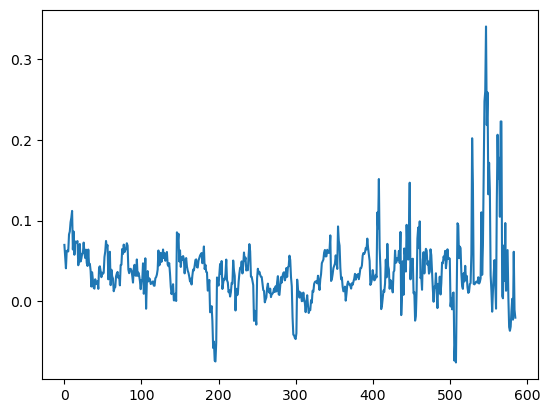

In [13]:
spread.prInc.plot()

<Axes: >

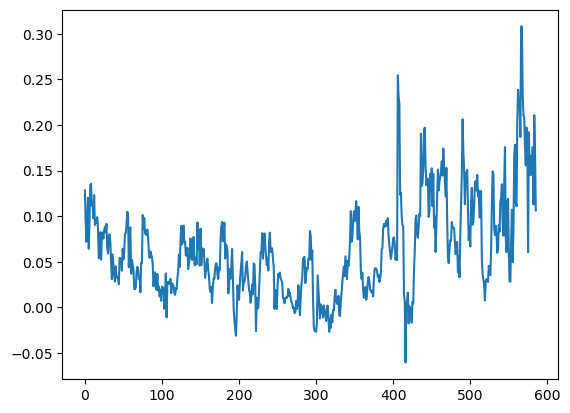

In [14]:
spread.prDec.plot()

# Helper Functions for Spread data Fetching

In [15]:
quandl.ApiConfig.api_key = 'NrLR6iDUF3zksCBL5eDQ'

In [16]:
@functools.lru_cache(maxsize=16)
def fetch_etf_data_quadl(ticker,start_date,end_date):
    return quandl.get_table('QUOTEMEDIA/PRICES', date = {'gte':start_date,'lte': end_date}, ticker=ticker)

In [17]:
@functools.lru_cache(maxsize=16)
def get_processed_data( tickers):
    security1 = tickers[0]
    security2 = tickers[1]
    
    rawdata_security1 = fetch_etf_data_quadl(security1 ,'2010-01-15','2024-01-10')
    rawdata_security2 = fetch_etf_data_quadl(security2 ,'2010-01-15','2024-01-10')

    rawdata_combined = pd.concat([rawdata_security1, rawdata_security2]).sort_values(['ticker','date']).reset_index(drop=True)

    rawdata_combined['adj_typical_price'] = (rawdata_combined['adj_high'] +  
                                             rawdata_combined['adj_low'] + rawdata_combined['adj_close']) / 3

    rawdata_combined['adj_dollar_vol'] = rawdata_combined['adj_volume'] * rawdata_combined['adj_close']

    rawdata_combined['adj_rolling_dollar_vol'] = rawdata_combined.groupby('ticker')['adj_dollar_vol'].rolling(15).median().reset_index(drop=True)
    
    return rawdata_combined

In [18]:
rawdata_combined = get_processed_data(tickers)

In [19]:
# rawdata_combined = rawdata_combined.set_index('date')
rawdata_combined 

,ticker,date,open,high,low,close,volume,dividend,split,adj_open,adj_high,adj_low,adj_close,adj_volume,adj_typical_price,adj_dollar_vol,adj_rolling_dollar_vol
0,CORN,2010-06-09,25.12,25.250,25.1200,25.1500,1700.0,0.0,1.0,25.12,25.250,25.1200,25.1500,1700.0,25.173333,42755.00,NaN
1,CORN,2010-06-10,25.46,25.460,25.4599,25.4599,200.0,0.0,1.0,25.46,25.460,25.4599,25.4599,200.0,25.459933,5091.98,NaN
2,CORN,2010-06-11,25.88,25.880,25.7913,25.7913,500.0,0.0,1.0,25.88,25.880,25.7913,25.7913,500.0,25.820867,12895.65,NaN
3,CORN,2010-06-14,25.99,26.110,25.9900,26.1100,2200.0,0.0,1.0,25.99,26.110,25.9900,26.1100,2200.0,26.070000,57442.00,NaN
4,CORN,2010-06-15,26.24,26.240,25.9690,25.9690,7000.0,0.0,1.0,26.24,26.240,25.9690,25.9690,7000.0,26.059333,181783.00,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6514,SOYB,2024-01-04,26.39,26.525,26.2400,26.4700,29859.0,0.0,1.0,26.39,26.525,26.2400,26.4700,29859.0,26.411667,790367.73,397496.88
6515,SOYB,2024-01-05,26.13,26.400,26.1300,26.1800,14826.0,0.0,1.0,26.13,26.400,26.1300,26.1800,14826.0,26.236667,388144.68,388144.68
6516,SOYB,2024-01-08,25.97,26.050,25.8050,26.0500,17101.0,0.0,1.0,25.97,26.050,25.8050,26.0500,17101.0,25.968333,445481.05,397496.88
6517,SOYB,2024-01-09,25.90,26.110,25.8500,26.1100,9995.0,0.0,1.0,25.90,26.110,25.8500,26.1100,9995.0,26.023333,260969.45,397496.88


In [20]:
merged_data = mpd_stats.merge(rawdata_combined, left_on=['idt','market'] , right_on=['date','ticker'])
merged_data

,market,maturity_target,mu,sd,skew,kurt,p10,p50,p90,lg_change_decr,...,dividend,split,adj_open,adj_high,adj_low,adj_close,adj_volume,adj_typical_price,adj_dollar_vol,adj_rolling_dollar_vol
0,CORN,6.0,-0.039462,0.255162,0.360685,0.493576,-0.345066,-0.056920,0.292564,-20.0,...,0.0,1.0,37.0500,37.4900,37.0000,37.4800,52100.0,37.323333,1952708.00,2491851.40
1,CORN,6.0,-0.031783,0.271860,0.335411,0.509822,-0.360761,-0.046420,0.318181,-20.0,...,0.0,1.0,34.9000,34.9795,34.3301,34.5130,66000.0,34.607533,2277858.00,2277858.00
2,CORN,6.0,-0.047725,0.291413,0.151623,0.234270,-0.408922,-0.056592,0.329120,-20.0,...,0.0,1.0,38.5900,39.0990,38.5800,39.0100,37300.0,38.896333,1455073.00,1458236.00
3,CORN,6.0,-0.027341,0.262186,0.233627,0.269733,-0.348753,-0.040734,0.314471,-20.0,...,0.0,1.0,40.4600,41.0300,40.4100,41.0000,57200.0,40.813333,2345200.00,2879328.00
4,CORN,6.0,-0.039574,0.278278,0.086250,0.065251,-0.388493,-0.047222,0.322980,-20.0,...,0.0,1.0,43.3900,43.7200,43.0000,43.7100,108400.0,43.476667,4738164.00,6688885.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1152,SOYB,6.0,-0.000860,0.130810,-0.912080,1.175880,-0.188880,0.023710,0.136390,-20.0,...,0.0,1.0,27.7200,27.7200,27.5300,27.7100,34093.0,27.653333,944717.03,525942.48
1153,SOYB,6.0,0.000010,0.130890,-1.080030,1.516480,-0.194680,0.026980,0.131530,-20.0,...,0.0,1.0,27.5500,27.5500,27.3400,27.3400,8917.0,27.410000,243790.78,457109.26
1154,SOYB,6.0,0.002150,0.124340,-1.020280,1.415740,-0.175330,0.026150,0.131400,-20.0,...,0.0,1.0,27.3158,27.4490,27.3000,27.4194,6400.0,27.389467,175484.16,340683.75
1155,SOYB,6.0,-0.002360,0.135720,-1.222660,1.693980,-0.208040,0.030130,0.129560,-20.0,...,0.0,1.0,26.4600,26.6700,26.4412,26.6400,18937.0,26.583733,504481.68,397496.88


In [21]:
window=8
spread_cols = list(mpd_stats.columns) + ['date', 'adj_close', 'adj_volume']
merged_data_filtered = merged_data[spread_cols].set_index('date')
merged_data_filtered.groupby('market')['adj_close']
merged_data_filtered

,market,maturity_target,mu,sd,skew,kurt,p10,p50,p90,lg_change_decr,prDec,lg_change_incr,prInc,adj_close,adj_volume
date,,,,,,,,,,,,,,,
2010-10-29,CORN,6.0,-0.039462,0.255162,0.360685,0.493576,-0.345066,-0.056920,0.292564,-20.0,0.259879,20.0,0.162105,37.4800,52100.0
2010-11-30,CORN,6.0,-0.031783,0.271860,0.335411,0.509822,-0.360761,-0.046420,0.318181,-20.0,0.263078,20.0,0.177533,34.5130,66000.0
2010-12-31,CORN,6.0,-0.047725,0.291413,0.151623,0.234270,-0.408922,-0.056592,0.329120,-20.0,0.296941,20.0,0.185053,39.0100,37300.0
2011-01-31,CORN,6.0,-0.027341,0.262186,0.233627,0.269733,-0.348753,-0.040734,0.314471,-20.0,0.252527,20.0,0.184116,41.0000,57200.0
2011-02-28,CORN,6.0,-0.039574,0.278278,0.086250,0.065251,-0.388493,-0.047222,0.322980,-20.0,0.281513,20.0,0.191938,43.7100,108400.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-13,SOYB,6.0,-0.000860,0.130810,-0.912080,1.175880,-0.188880,0.023710,0.136390,-20.0,0.091260,20.0,0.028840,27.7100,34093.0
2023-12-20,SOYB,6.0,0.000010,0.130890,-1.080030,1.516480,-0.194680,0.026980,0.131530,-20.0,0.096120,20.0,0.024700,27.3400,8917.0
2023-12-27,SOYB,6.0,0.002150,0.124340,-1.020280,1.415740,-0.175330,0.026150,0.131400,-20.0,0.080840,20.0,0.020710,27.4194,6400.0


In [22]:
window = 8

merged_data_filtered = merged_data[spread_cols].set_index('date')

for col in ['adj_close', 'prInc', 'prDec']:
    group_means = merged_data_filtered.groupby('market')[col].rolling(window=window).mean().reset_index(level=0, drop=True)
    group_stds = merged_data_filtered.groupby('market')[col].rolling(window=window).std().reset_index(level=0, drop=True)
    normalized_values = (merged_data_filtered[col] - group_means) / group_stds
    merged_data_filtered[f'norm_rolling_{col}'] = normalized_values

merged_data_filtered.tail()

,market,maturity_target,mu,sd,skew,kurt,p10,p50,p90,lg_change_decr,prDec,lg_change_incr,prInc,adj_close,adj_volume,norm_rolling_adj_close,norm_rolling_prInc,norm_rolling_prDec
date,,,,,,,,,,,,,,,,,,
2023-12-13,SOYB,6.0,-0.00086,0.13081,-0.91208,1.17588,-0.18888,0.02371,0.13639,-20.0,0.09126,20.0,0.02884,27.7100,34093.0,-0.491514,-1.191541,0.480035
2023-12-20,SOYB,6.0,0.00001,0.13089,-1.08003,1.51648,-0.19468,0.02698,0.13153,-20.0,0.09612,20.0,0.02470,27.3400,8917.0,-1.154765,-1.261076,0.743128
2023-12-27,SOYB,6.0,0.00215,0.12434,-1.02028,1.41574,-0.17533,0.02615,0.13140,-20.0,0.08084,20.0,0.02071,27.4194,6400.0,-0.982283,-1.168730,-0.271498
2024-01-03,SOYB,6.0,-0.00236,0.13572,-1.22266,1.69398,-0.20804,0.03013,0.12956,-20.0,0.10593,20.0,0.02030,26.6400,18937.0,-1.565158,-0.942163,1.617775
2024-01-10,SOYB,6.0,-0.00800,0.17895,-1.13727,0.53654,-0.29424,0.05576,0.15587,-20.0,0.19172,20.0,0.03663,25.9300,13779.0,-1.776225,0.281039,2.397070


In [23]:
spreads_df = (merged_data_filtered[merged_data_filtered.market==security1].iloc[:,2:] - 
                        merged_data_filtered[merged_data_filtered.market==security2].iloc[:,2:])
spreads_df

,mu,sd,skew,kurt,p10,p50,p90,lg_change_decr,prDec,lg_change_incr,prInc,adj_close,adj_volume,norm_rolling_adj_close,norm_rolling_prInc,norm_rolling_prDec
date,,,,,,,,,,,,,,,,
2010-10-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-11-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-13,-0.02985,0.09499,-0.24592,-1.09549,-0.20938,0.04502,0.02110,0.0,0.17582,0.0,0.00330,-5.7956,83444.0,-0.350747,0.868960,0.459415
2023-12-20,-0.04183,0.08832,-0.48308,-0.30732,-0.23270,0.02330,-0.01591,0.0,0.11296,0.0,-0.02247,-5.8200,106412.0,-0.766858,0.331438,-1.424111
2023-12-27,-0.01940,0.11635,0.02433,-1.73090,-0.21888,0.07065,0.06030,0.0,0.21084,0.0,0.06153,-5.6794,19613.0,0.230352,3.255129,2.002526


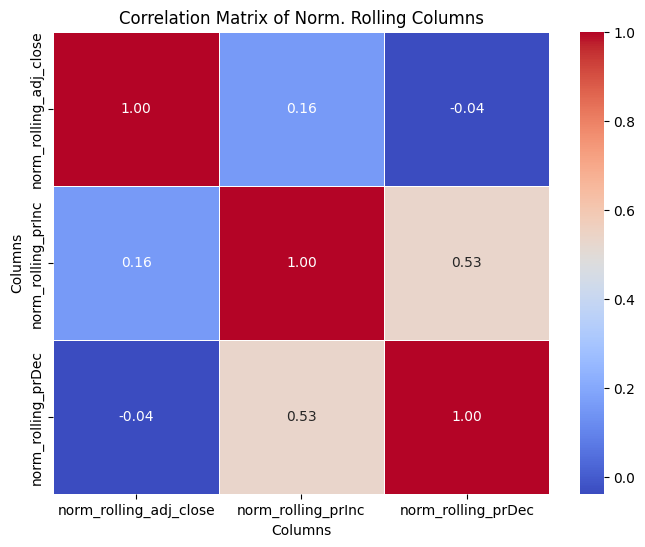

In [113]:

spreads_corr = spreads_df[[ 'norm_rolling_adj_close', 'norm_rolling_prInc', 'norm_rolling_prDec']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(spreads_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Norm. Rolling Columns')
plt.xlabel('Columns')
plt.ylabel('Columns')
plt.show()

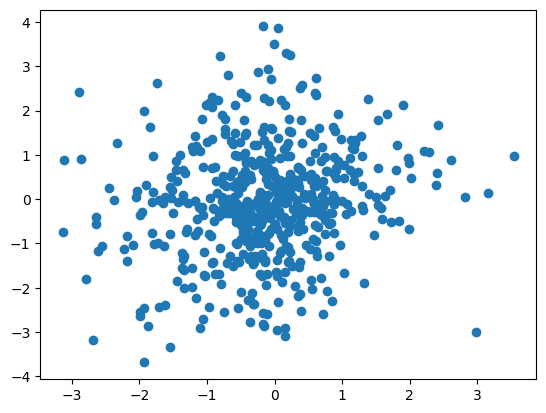

In [23]:
plt.scatter(spreads_df['norm_rolling_adj_close'], spreads_df['norm_rolling_prInc'])

In [26]:
#nd=next day
rawdata_combined_processed = rawdata_combined.sort_values(['ticker','date'])
rawdata_combined_processed = rawdata_combined_processed.set_index(['date'])

rawdata_combined_processed = rawdata_combined_processed[['adj_close', 'adj_volume']]
rawdata_combined_processed[['nd_adj_close', 'nd_adj_volume']] = rawdata_combined_processed[['adj_close', 'adj_volume']].shift(-1)#.dropna()#.reset_index()
rawdata_combined_processed['ticker'] = rawdata_combined.set_index('date').ticker
rawdata_combined_processed

,adj_close,adj_volume,nd_adj_close,nd_adj_volume,ticker
date,,,,,
2010-06-09,25.1500,1700.0,25.4599,200.0,CORN
2010-06-10,25.4599,200.0,25.7913,500.0,CORN
2010-06-11,25.7913,500.0,26.1100,2200.0,CORN
2010-06-14,26.1100,2200.0,25.9690,7000.0,CORN
2010-06-15,25.9690,7000.0,26.3200,2400.0,CORN
...,...,...,...,...,...
2024-01-04,26.4700,29859.0,26.1800,14826.0,SOYB
2024-01-05,26.1800,14826.0,26.0500,17101.0,SOYB
2024-01-08,26.0500,17101.0,26.1100,9995.0,SOYB


In [212]:
BAC_data = rawdata_combined_processed[rawdata_combined_processed.ticker==security1][['nd_adj_close', 'nd_adj_volume']]
BAC_data.columns = [security1, f'{security1}_adj_volume']
CITI_data = rawdata_combined_processed[rawdata_combined_processed.ticker==security2][['nd_adj_close', 'nd_adj_volume']]
CITI_data.columns = [security2, f'{security2}_adj_volume']
spreads_df_merged = spreads_df.merge(BAC_data, left_index=True, right_index=True)
spreads_df_merged = spreads_df_merged.merge(CITI_data, left_index=True, right_index=True)
spreads_df_merged['spread'] = np.nan
spreads_df_merged['spread2'] = np.nan
spreads_df_merged['price_spread'] = np.nan
spreads_df_merged['dollars_available'] = np.nan
spreads_df_merged

,mu,sd,skew,kurt,p10,p50,p90,lg_change_decr,prDec,lg_change_incr,...,norm_rolling_prInc,norm_rolling_prDec,CORN,CORN_adj_volume,SOYB,SOYB_adj_volume,spread,spread2,price_spread,dollars_available
date,,,,,,,,,,,,,,,,,,,,,
2011-09-23,-0.007875,0.058621,-0.114580,-0.079516,-0.084706,-0.005990,0.066257,0.0,0.090427,0.0,...,NaN,NaN,43.210,71000.0,23.46,1000.0,NaN,NaN,NaN,NaN
2011-10-06,-0.010665,0.072847,0.060276,-0.159343,-0.103110,-0.012921,0.084966,0.0,0.095295,0.0,...,NaN,NaN,40.550,34400.0,21.73,1100.0,NaN,NaN,NaN,NaN
2011-10-20,-0.008018,0.067386,0.060957,-0.193980,-0.095199,-0.009236,0.079617,0.0,0.093068,0.0,...,NaN,NaN,43.340,105500.0,22.58,1500.0,NaN,NaN,NaN,NaN
2011-11-03,-0.011622,0.067336,0.035617,-0.293945,-0.098424,-0.014156,0.080542,0.0,0.099099,0.0,...,NaN,NaN,43.540,56900.0,22.52,1000.0,NaN,NaN,NaN,NaN
2011-11-17,-0.007733,0.059583,0.092920,-0.350465,-0.084074,-0.012249,0.078139,0.0,0.086221,0.0,...,NaN,NaN,40.230,93900.0,21.60,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-13,-0.029850,0.094990,-0.245920,-1.095490,-0.209380,0.045020,0.021100,0.0,0.175820,0.0,...,0.868960,0.459415,21.945,28134.0,27.84,11814.0,NaN,NaN,NaN,NaN
2023-12-20,-0.041830,0.088320,-0.483080,-0.307320,-0.232700,0.023300,-0.015910,0.0,0.112960,0.0,...,0.331438,-1.424111,21.660,45694.0,27.15,11045.0,NaN,NaN,NaN,NaN
2023-12-27,-0.019400,0.116350,0.024330,-1.730900,-0.218880,0.070650,0.060300,0.0,0.210840,0.0,...,3.255129,2.002526,21.730,59528.0,27.28,14571.0,NaN,NaN,NaN,NaN


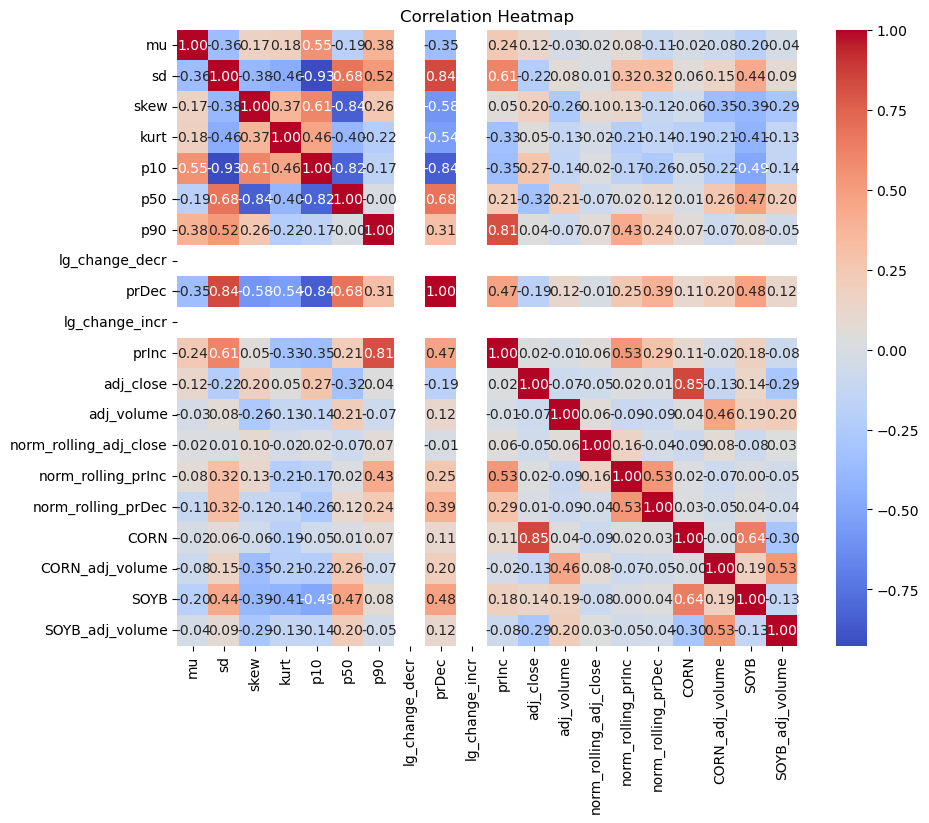

In [203]:
correlation_matrix = spreads_df_merged.corr()

# Creating a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

In [213]:

# Function to perform ADF test and extract p-value
def adf_test(series):
    result = adfuller(series)
    p_value = result[1]  # Extract p-value
    return p_value

# Create an empty list to store results
results = []

# List of columns
columns = ['norm_rolling_prDec', 'norm_rolling_prInc', 'norm_rolling_adj_close']
map = {}
map['norm_rolling_prDec'] = 'prDec'
map['norm_rolling_prInc'] = 'prInc'
map['norm_rolling_adj_close'] = 'price'
# Perform ADF test for each column and store p-value in list
for col in columns:
    p_value = adf_test(spreads_df_merged[col].dropna())
    results.append({'Z Score': map[col], 'P-value of ADF test': p_value})

# Convert the list to a DataFrame
results_df = pd.DataFrame(results)

# Display the DataFrame
results_df


,Z Score,P-value of ADF test
0,prDec,1.546161e-17
1,prInc,2.187127e-18
2,price,1.160935e-19


In [214]:


doc = Document()

# Add a table
table = doc.add_table(rows=1, cols=len(results_df.columns))

# Add borders to the table
for row in table.rows:
    for cell in row.cells:
        for paragraph in cell.paragraphs:
            for run in paragraph.runs:
                run.font.size = Pt(10)  # Adjust font size if needed
        cell.vertical_alignment = WD_ALIGN_VERTICAL.CENTER
        for edge in cell._element.xpath('.//*'):
            edge.set('sz', '24')  # Border size in twentieths of a point
            edge.set('space', '0')
            edge.set('color', '000000')  # Border color (black)

# Add column headers
hdr_cells = table.rows[0].cells
for i, col in enumerate(results_df.columns):
    hdr_cells[i].text = col

# Add data to the table
for index, row in results_df.iterrows():
    row_cells = table.add_row().cells
    for i, value in enumerate(row):
        row_cells[i].text = str(value)


# Save the document
doc.save('Corn Soyabean ADF.docx')

NameError: name 'Document' is not defined

# Price Increase Probablity as spread

In [215]:
cap=1e9

In [216]:
spreads_df_merged['spread'] = spreads_df_merged['prInc']
spreads_df_merged['dollars_available'] = cap
spreads_df_merged

,mu,sd,skew,kurt,p10,p50,p90,lg_change_decr,prDec,lg_change_incr,...,norm_rolling_prInc,norm_rolling_prDec,CORN,CORN_adj_volume,SOYB,SOYB_adj_volume,spread,spread2,price_spread,dollars_available
date,,,,,,,,,,,,,,,,,,,,,
2011-09-23,-0.007875,0.058621,-0.114580,-0.079516,-0.084706,-0.005990,0.066257,0.0,0.090427,0.0,...,NaN,NaN,43.210,71000.0,23.46,1000.0,0.057823,NaN,NaN,1.000000e+09
2011-10-06,-0.010665,0.072847,0.060276,-0.159343,-0.103110,-0.012921,0.084966,0.0,0.095295,0.0,...,NaN,NaN,40.550,34400.0,21.73,1100.0,0.074229,NaN,NaN,1.000000e+09
2011-10-20,-0.008018,0.067386,0.060957,-0.193980,-0.095199,-0.009236,0.079617,0.0,0.093068,0.0,...,NaN,NaN,43.340,105500.0,22.58,1500.0,0.073957,NaN,NaN,1.000000e+09
2011-11-03,-0.011622,0.067336,0.035617,-0.293945,-0.098424,-0.014156,0.080542,0.0,0.099099,0.0,...,NaN,NaN,43.540,56900.0,22.52,1000.0,0.073055,NaN,NaN,1.000000e+09
2011-11-17,-0.007733,0.059583,0.092920,-0.350465,-0.084074,-0.012249,0.078139,0.0,0.086221,0.0,...,NaN,NaN,40.230,93900.0,21.60,0.0,0.074721,NaN,NaN,1.000000e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-13,-0.029850,0.094990,-0.245920,-1.095490,-0.209380,0.045020,0.021100,0.0,0.175820,0.0,...,0.868960,0.459415,21.945,28134.0,27.84,11814.0,0.003300,NaN,NaN,1.000000e+09
2023-12-20,-0.041830,0.088320,-0.483080,-0.307320,-0.232700,0.023300,-0.015910,0.0,0.112960,0.0,...,0.331438,-1.424111,21.660,45694.0,27.15,11045.0,-0.022470,NaN,NaN,1.000000e+09
2023-12-27,-0.019400,0.116350,0.024330,-1.730900,-0.218880,0.070650,0.060300,0.0,0.210840,0.0,...,3.255129,2.002526,21.730,59528.0,27.28,14571.0,0.061530,NaN,NaN,1.000000e+09


In [217]:

def tune_hyperparameter(spreads_df, K= 1e10, g=0.03, j=0, s=-100, tc=0, reverse=False, interactive_plot=True):
    def get_raw_positions(spreads_df, sl_exit):
        spreads_df = spreads_df.copy()
        spreads_df['signal'] = np.nan

        buy_condition = (spreads_df['spread'] > g) 
        sell_condition = (spreads_df['spread'] < -g)
        
        if reverse:
            cond=sell_condition.copy()
            sell_condition = buy_condition.copy()
            buy_condition = cond.copy()

        # Generate signals
        spreads_df.loc[buy_condition, 'signal'] = 1
        spreads_df.loc[sell_condition, 'signal'] = -1

        spreads_df['position'] = spreads_df['signal'].ffill()

        # Exit the position if the spread becomes flat (goes below j)
        sell_exit_cond = (spreads_df['position'] == -1) & (spreads_df['spread'] <= g) & (spreads_df['spread'] >= -j)
        buy_exit_cond = (spreads_df['position'] == 1) & (spreads_df['spread'] >= -g) & (spreads_df['spread'] <= j)
        
        if reverse:
            cond=sell_exit_cond.copy()
            sell_exit_cond = buy_exit_cond.copy()
            buy_exit_cond = cond.copy()
        
        if sl_exit is not None:
            spreads_df.loc[sl_exit, 'signal'] = 0

        # last day exit
        spreads_df['signal'].iloc[-1] = 0

        # normal exits
        spreads_df.loc[sell_exit_cond, 'signal'] = 0
        spreads_df.loc[buy_exit_cond, 'signal'] = 0
        spreads_df['position'] = spreads_df['signal'].ffill()

        # Create new_signal column representing changes in position
        spreads_df['final_signal'] = np.nan
        spreads_df['position'].fillna(0, inplace=True)

        spreads_df['new_position'] = 0
        spreads_df.loc[
            (spreads_df['position'].shift() != spreads_df['position']) & (
                        spreads_df['position'] != 0), 'new_position'] = 1
        spreads_df['position_count'] = spreads_df['new_position'].cumsum()

        spreads_df['final_signal'] = spreads_df['position'].diff()

        return spreads_df

    raw_positions = get_raw_positions(spreads_df, None)

    def process_positions(raw_positions):
        positions_df = raw_positions.copy()

        positions_df[security1 + '_' + 'quantity_held'] = np.nan
        positions_df[security2 + '_' + 'quantity_held'] = np.nan

        positions_df.loc[(positions_df.final_signal != 0), security1 + '_' + 'quantity_held'] = positions_df[
                                                                                                    'position'] * (
                                                                                                        positions_df[
                                                                                                            'dollars_available'] /
                                                                                                        positions_df[
                                                                                                            security1]).round()
        positions_df.loc[(positions_df.final_signal != 0), security2 + '_' + 'quantity_held'] = -1 * positions_df[
            'position'] * (positions_df['dollars_available'] / positions_df[security2]).round()

        positions_df[security1 + '_' + 'quantity_held'].ffill(inplace=True)
        positions_df[security2 + '_' + 'quantity_held'].ffill(inplace=True)

        positions_df['net_dollar_position'] = (
                    positions_df[security1 + '_' + 'quantity_held'] * positions_df[security1] +
                    positions_df[security2 + '_' + 'quantity_held'] * positions_df[security2])
        positions_df['gross_dollar_position'] = (
                (positions_df[security1 + '_' + 'quantity_held'] * positions_df[security1]).abs() +
                (positions_df[security2 + '_' + 'quantity_held'] * positions_df[security2]).abs())
        positions_df['net_dollar_position_change'] = (
                positions_df[security1 + '_' + 'quantity_held'].shift() * positions_df[security1].diff() +
                positions_df[security2 + '_' + 'quantity_held'].shift() * positions_df[security2].diff()).shift(-1)

        positions_df['transaction_cost'] = (
                                                   positions_df[security1 + '_' + 'quantity_held'].diff().abs() *
                                                   positions_df[security1] +
                                                   positions_df[security2 + '_' + 'quantity_held'].diff().abs() *
                                                   positions_df[security2]) * tc

        positions_df['position_pnl'] = positions_df.groupby(['position_count'])['net_dollar_position_change'].cumsum()

        positions_df['position_returns'] = (
                positions_df.groupby(['position_count'])['net_dollar_position_change'].cumsum() /
                positions_df.groupby('position_count')['gross_dollar_position'].transform('first'))

        return positions_df

    positions = process_positions(raw_positions)

    def implement_stop_loss(positions, sl_implemented):

        positions_df = positions.copy()

        positions_df['sl_not_hit'] = np.nan
        positions_df.loc[positions_df['new_position'] == 1, 'sl_not_hit'] = 1
        positions_df.loc[positions_df.groupby('position_count')['position_returns'].shift() <= s, 'sl_not_hit'] = 0
        positions_df['sl_not_hit'].ffill(inplace=True)
        positions_df['sl_not_hit'].fillna(1, inplace=True)

        positions_df['month'] = positions_df.index.strftime('%Y-%m')
        positions_df['monthly_sl_not_hit'] = positions_df.groupby('month')['sl_not_hit'].cummin()
        sl_exits = positions_df['monthly_sl_not_hit'] == 0

        if sl_implemented:
            return positions_df

        spreads_df = positions_df.loc[:, :'dollars_available']
        raw_positions = get_raw_positions(spreads_df, sl_exits)
        final_positions = process_positions(raw_positions)

        final_positions_sl = implement_stop_loss(final_positions, True)
        return final_positions_sl

    positions_sl_implemented = implement_stop_loss(positions, False)

    def calculate_and_plot_pnl(positions):

        positions = positions.copy()

        grouped_pnl_pct = (positions.groupby('position_count')['net_dollar_position_change'].sum() -
                           positions.groupby('position_count')['transaction_cost'].sum()) / \
                          positions.groupby('position_count')['gross_dollar_position'].first()

        positions['total_pnl'] = positions['net_dollar_position_change'].cumsum() - positions[
            'transaction_cost'].cumsum()
        positions['cumulative_pnl'] = positions['total_pnl'] + K

        return grouped_pnl_pct, positions

    grouped_pnl_pct, positions_pnl = calculate_and_plot_pnl(positions_sl_implemented)

    plt.figure(figsize=(12, 8))
    positions_pnl.total_pnl.plot(color='blue', linewidth=2, label='Total PnL')
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Total PnL (USD)', fontsize=14)
    plt.title('Total PnL Over Time', fontsize=16)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(fontsize=12)
    plt.show()

    cumulative_pnl = positions_pnl['cumulative_pnl'].dropna()
    cumulative_returns_percentage = ((cumulative_pnl / cumulative_pnl.iloc[0] - 1) * 100)
    cumulative_returns_percentage.plot(figsize=(12, 8), color='green', linewidth=2)

    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Cumulative Returns (%)', fontsize=14)
    plt.title('Cumulative Returns Over Time', fontsize=16)
    plt.grid(True, linestyle='--', alpha=0.6)

    if not interactive_plot:
        return grouped_pnl_pct, positions_pnl

    return positions_pnl.total_pnl



In [218]:

# tune_hyperparameter(spreads_df_merged,K =1e10, g=0.03, j=0, s=-100, tc=0, interactive_plot=True)


In [219]:
from ipywidgets import interactive

# Define your function that generates the plot based on parameters
def update_plot(K=1e10, g=0, j=0, s=-100, tc = 0, reverse=False):

    positions_pnl = tune_hyperparameter(spreads_df_merged,K, g, j, s, tc,reverse)


# Create sliders for varying features
# M_slider = range(5,100, 5) 
# k_slider = np.linspace(0, cap/20, num=101)
g_slider = np.linspace(0, 0.05, num=501)
j_slider = np.linspace(0, 0.05, num=501)
s_slider = np.linspace(-100, 0, num=101)
tc_slider = np.linspace(0, 0.00005, num=6)


In [220]:
# Create interactive plot
interactive_plot = interactive(update_plot,K=cap, g=g_slider, j=j_slider, s=s_slider, tc = tc_slider)
output = interactive_plot.children[-1]
interactive_plot

interactive(children=(FloatSlider(value=1000000000.0, description='K', max=3000000000.0, min=-1000000000.0), D…

# Strategy based on price decrease probablity

In [221]:
check_stationarity(spreads_df_merged['prDec'])

ADF Statistic: -3.1373561011987214
p-value: 0.023909370020420026
Critical Values: {'1%': -3.4421447800270673, '5%': -2.8667429272780858, '10%': -2.5695409929766093}
The time series is stationary.


In [222]:
spreads_df_merged['spread'] = -spreads_df_merged['prDec']
spreads_df_merged['dollars_available'] = cap
spreads_df_merged

,mu,sd,skew,kurt,p10,p50,p90,lg_change_decr,prDec,lg_change_incr,...,norm_rolling_prInc,norm_rolling_prDec,CORN,CORN_adj_volume,SOYB,SOYB_adj_volume,spread,spread2,price_spread,dollars_available
date,,,,,,,,,,,,,,,,,,,,,
2011-09-23,-0.007875,0.058621,-0.114580,-0.079516,-0.084706,-0.005990,0.066257,0.0,0.090427,0.0,...,NaN,NaN,43.210,71000.0,23.46,1000.0,-0.090427,NaN,NaN,1.000000e+09
2011-10-06,-0.010665,0.072847,0.060276,-0.159343,-0.103110,-0.012921,0.084966,0.0,0.095295,0.0,...,NaN,NaN,40.550,34400.0,21.73,1100.0,-0.095295,NaN,NaN,1.000000e+09
2011-10-20,-0.008018,0.067386,0.060957,-0.193980,-0.095199,-0.009236,0.079617,0.0,0.093068,0.0,...,NaN,NaN,43.340,105500.0,22.58,1500.0,-0.093068,NaN,NaN,1.000000e+09
2011-11-03,-0.011622,0.067336,0.035617,-0.293945,-0.098424,-0.014156,0.080542,0.0,0.099099,0.0,...,NaN,NaN,43.540,56900.0,22.52,1000.0,-0.099099,NaN,NaN,1.000000e+09
2011-11-17,-0.007733,0.059583,0.092920,-0.350465,-0.084074,-0.012249,0.078139,0.0,0.086221,0.0,...,NaN,NaN,40.230,93900.0,21.60,0.0,-0.086221,NaN,NaN,1.000000e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-13,-0.029850,0.094990,-0.245920,-1.095490,-0.209380,0.045020,0.021100,0.0,0.175820,0.0,...,0.868960,0.459415,21.945,28134.0,27.84,11814.0,-0.175820,NaN,NaN,1.000000e+09
2023-12-20,-0.041830,0.088320,-0.483080,-0.307320,-0.232700,0.023300,-0.015910,0.0,0.112960,0.0,...,0.331438,-1.424111,21.660,45694.0,27.15,11045.0,-0.112960,NaN,NaN,1.000000e+09
2023-12-27,-0.019400,0.116350,0.024330,-1.730900,-0.218880,0.070650,0.060300,0.0,0.210840,0.0,...,3.255129,2.002526,21.730,59528.0,27.28,14571.0,-0.210840,NaN,NaN,1.000000e+09


In [223]:
from ipywidgets import interactive

# Define your function that generates the plot based on parameters
def update_plot(K=1e10, g=0.03, j=0, s=-100, tc = 0, reverse=False):

    positions_pnl = tune_hyperparameter(spreads_df_merged,K, g, j, s, tc, reverse)


# Create sliders for varying features
# M_slider = range(5,100, 5) 
# k_slider = np.linspace(0, cap/20, num=101)
g_slider = np.linspace(0, 0.05, num=501)
j_slider = np.linspace(0, 0.05, num=501)
s_slider = np.linspace(-100, 0, num=101)
tc_slider = np.linspace(0, 0.00005, num=6)


# Create interactive plot
interactive_plot = interactive(update_plot,K=cap, g=g_slider, j=j_slider, s=s_slider, tc = tc_slider, reverse=True)
output = interactive_plot.children[-1]
interactive_plot

interactive(children=(FloatSlider(value=1000000000.0, description='K', max=3000000000.0, min=-1000000000.0), D…

### We see that for the same set of parameters for a strategy, Price Increase porbablity and price decrease probablity lead to very different PnL.

## Strategy based on normalized increasing probablities

In [224]:
spreads_df_merged['spread'] = spreads_df_merged['norm_rolling_prInc']
spreads_df_merged['dollars_available'] = cap
spreads_df_merged

,mu,sd,skew,kurt,p10,p50,p90,lg_change_decr,prDec,lg_change_incr,...,norm_rolling_prInc,norm_rolling_prDec,CORN,CORN_adj_volume,SOYB,SOYB_adj_volume,spread,spread2,price_spread,dollars_available
date,,,,,,,,,,,,,,,,,,,,,
2011-09-23,-0.007875,0.058621,-0.114580,-0.079516,-0.084706,-0.005990,0.066257,0.0,0.090427,0.0,...,NaN,NaN,43.210,71000.0,23.46,1000.0,NaN,NaN,NaN,1.000000e+09
2011-10-06,-0.010665,0.072847,0.060276,-0.159343,-0.103110,-0.012921,0.084966,0.0,0.095295,0.0,...,NaN,NaN,40.550,34400.0,21.73,1100.0,NaN,NaN,NaN,1.000000e+09
2011-10-20,-0.008018,0.067386,0.060957,-0.193980,-0.095199,-0.009236,0.079617,0.0,0.093068,0.0,...,NaN,NaN,43.340,105500.0,22.58,1500.0,NaN,NaN,NaN,1.000000e+09
2011-11-03,-0.011622,0.067336,0.035617,-0.293945,-0.098424,-0.014156,0.080542,0.0,0.099099,0.0,...,NaN,NaN,43.540,56900.0,22.52,1000.0,NaN,NaN,NaN,1.000000e+09
2011-11-17,-0.007733,0.059583,0.092920,-0.350465,-0.084074,-0.012249,0.078139,0.0,0.086221,0.0,...,NaN,NaN,40.230,93900.0,21.60,0.0,NaN,NaN,NaN,1.000000e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-13,-0.029850,0.094990,-0.245920,-1.095490,-0.209380,0.045020,0.021100,0.0,0.175820,0.0,...,0.868960,0.459415,21.945,28134.0,27.84,11814.0,0.868960,NaN,NaN,1.000000e+09
2023-12-20,-0.041830,0.088320,-0.483080,-0.307320,-0.232700,0.023300,-0.015910,0.0,0.112960,0.0,...,0.331438,-1.424111,21.660,45694.0,27.15,11045.0,0.331438,NaN,NaN,1.000000e+09
2023-12-27,-0.019400,0.116350,0.024330,-1.730900,-0.218880,0.070650,0.060300,0.0,0.210840,0.0,...,3.255129,2.002526,21.730,59528.0,27.28,14571.0,3.255129,NaN,NaN,1.000000e+09


In [225]:

# signals reverse
def update_plot(K=1e10, g=0, j=0, s=-100, tc = 0, reverse=False):

    positions_pnl = tune_hyperparameter(spreads_df_merged,K, g, j, s, tc, reverse)


# Create sliders for varying features
# M_slider = range(5,100, 5) 
# k_slider = np.linspace(0, cap/20, num=101)
g_slider = np.linspace(0, 5, num=501)
j_slider = np.linspace(0, 5, num=501)
s_slider = np.linspace(-0.01, 0, num=101)
tc_slider = np.linspace(0, 0.00005, num=6)


# Create interactive plot
interactive_plot = interactive(update_plot,K=cap, g=g_slider, j=j_slider, s=s_slider, tc = tc_slider, reverse=False)
output = interactive_plot.children[-1]
interactive_plot

interactive(children=(FloatSlider(value=1000000000.0, description='K', max=3000000000.0, min=-1000000000.0), D…

## Strategy based on normalized decreasing probablities

In [226]:
spreads_df_merged['spread'] = -spreads_df_merged['norm_rolling_prDec']
spreads_df_merged['dollars_available'] = 1e9
spreads_df_merged

,mu,sd,skew,kurt,p10,p50,p90,lg_change_decr,prDec,lg_change_incr,...,norm_rolling_prInc,norm_rolling_prDec,CORN,CORN_adj_volume,SOYB,SOYB_adj_volume,spread,spread2,price_spread,dollars_available
date,,,,,,,,,,,,,,,,,,,,,
2011-09-23,-0.007875,0.058621,-0.114580,-0.079516,-0.084706,-0.005990,0.066257,0.0,0.090427,0.0,...,NaN,NaN,43.210,71000.0,23.46,1000.0,NaN,NaN,NaN,1.000000e+09
2011-10-06,-0.010665,0.072847,0.060276,-0.159343,-0.103110,-0.012921,0.084966,0.0,0.095295,0.0,...,NaN,NaN,40.550,34400.0,21.73,1100.0,NaN,NaN,NaN,1.000000e+09
2011-10-20,-0.008018,0.067386,0.060957,-0.193980,-0.095199,-0.009236,0.079617,0.0,0.093068,0.0,...,NaN,NaN,43.340,105500.0,22.58,1500.0,NaN,NaN,NaN,1.000000e+09
2011-11-03,-0.011622,0.067336,0.035617,-0.293945,-0.098424,-0.014156,0.080542,0.0,0.099099,0.0,...,NaN,NaN,43.540,56900.0,22.52,1000.0,NaN,NaN,NaN,1.000000e+09
2011-11-17,-0.007733,0.059583,0.092920,-0.350465,-0.084074,-0.012249,0.078139,0.0,0.086221,0.0,...,NaN,NaN,40.230,93900.0,21.60,0.0,NaN,NaN,NaN,1.000000e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-13,-0.029850,0.094990,-0.245920,-1.095490,-0.209380,0.045020,0.021100,0.0,0.175820,0.0,...,0.868960,0.459415,21.945,28134.0,27.84,11814.0,-0.459415,NaN,NaN,1.000000e+09
2023-12-20,-0.041830,0.088320,-0.483080,-0.307320,-0.232700,0.023300,-0.015910,0.0,0.112960,0.0,...,0.331438,-1.424111,21.660,45694.0,27.15,11045.0,1.424111,NaN,NaN,1.000000e+09
2023-12-27,-0.019400,0.116350,0.024330,-1.730900,-0.218880,0.070650,0.060300,0.0,0.210840,0.0,...,3.255129,2.002526,21.730,59528.0,27.28,14571.0,-2.002526,NaN,NaN,1.000000e+09


In [227]:

# signals reverse
def update_plot(K=1e10, g=0, j=0, s=-100, tc = 0, reverse=False):

    positions_pnl = tune_hyperparameter(spreads_df_merged,K, g, j, s, tc, reverse)


# Create sliders for varying features
# M_slider = range(5,100, 5) 
# k_slider = np.linspace(0, cap/20, num=101)
g_slider = np.linspace(0, 5, num=501)
j_slider = np.linspace(-1, 5, num=601)
s_slider = np.linspace(-0.01, 0, num=101)
tc_slider = np.linspace(0, 0.00005, num=6)


# Create interactive plot
interactive_plot = interactive(update_plot,K=cap, g=g_slider, j=j_slider, s=s_slider, tc = tc_slider, reverse=False)
output = interactive_plot.children[-1]
interactive_plot

interactive(children=(FloatSlider(value=1000000000.0, description='K', max=3000000000.0, min=-1000000000.0), D…

# OOS Strategy performance on probability spreads

In [228]:

def one_spread_strat(spreads_df, K= 1e10, g=0.03, j=0, s=-100, tc=0, reverse=False, interactive_plot=True):
    
    def get_raw_positions(spreads_df, sl_exit):
        spreads_df = spreads_df.copy()
        spreads_df['signal'] = np.nan

        buy_condition = (spreads_df['spread'] > g)  
        sell_condition = (spreads_df['spread'] < -g) 
        
        if reverse:
            sell_condition = (spreads_df['spread'] > g)
            buy_condition = (spreads_df['spread'] < -g)

        # Generate signals
        spreads_df.loc[buy_condition, 'signal'] = 1
        spreads_df.loc[sell_condition, 'signal'] = -1

        spreads_df['position'] = spreads_df['signal'].ffill()

        # Exit the position if the spread becomes flat (goes below j)
        sell_exit_cond = (spreads_df['position'] == -1) & (spreads_df['spread'] <= g) & (spreads_df['spread'] >= -j)
        buy_exit_cond = (spreads_df['position'] == 1) & (spreads_df['spread'] >= -g) & (spreads_df['spread'] <= j)
        
        if reverse:
            sell_exit_cond = (spreads_df['position'] == -1) & (spreads_df['spread'] >= -g) & (spreads_df['spread'] <= j)
            buy_exit_cond = (spreads_df['position'] == 1) & (spreads_df['spread'] <= g) & (spreads_df['spread'] >= -j)
        
        if sl_exit is not None:
            spreads_df.loc[sl_exit, 'signal'] = 0

        # last day exit
        spreads_df['signal'].iloc[-1] = 0

        # normal exits
        spreads_df.loc[sell_exit_cond, 'signal'] = 0
        spreads_df.loc[buy_exit_cond, 'signal'] = 0
        spreads_df['position'] = spreads_df['signal'].ffill()

        # Create new_signal column representing changes in position
        spreads_df['final_signal'] = np.nan
        spreads_df['position'].fillna(0, inplace=True)

        spreads_df['new_position'] = 0
        spreads_df.loc[
            (spreads_df['position'].shift() != spreads_df['position']) & (
                        spreads_df['position'] != 0), 'new_position'] = 1
        spreads_df['position_count'] = spreads_df['new_position'].cumsum()

        spreads_df['final_signal'] = spreads_df['position'].diff()

        return spreads_df

    raw_positions = get_raw_positions(spreads_df, None)

    def process_positions(raw_positions):
        positions_df = raw_positions.copy()

        positions_df[security1 + '_' + 'quantity_held'] = np.nan
        positions_df[security2 + '_' + 'quantity_held'] = np.nan

        positions_df.loc[(positions_df.final_signal != 0), security1 + '_' + 'quantity_held'] = positions_df[
                                                                                                    'position'] * (
                                                                                                        positions_df[
                                                                                                            'dollars_available'] /
                                                                                                        positions_df[
                                                                                                            security1]).round()
        positions_df.loc[(positions_df.final_signal != 0), security2 + '_' + 'quantity_held'] = -1 * positions_df[
            'position'] * (positions_df['dollars_available'] / positions_df[security2]).round()

        positions_df[security1 + '_' + 'quantity_held'].ffill(inplace=True)
        positions_df[security2 + '_' + 'quantity_held'].ffill(inplace=True)

        positions_df['net_dollar_position'] = (
                    positions_df[security1 + '_' + 'quantity_held'] * positions_df[security1] +
                    positions_df[security2 + '_' + 'quantity_held'] * positions_df[security2])
        positions_df['gross_dollar_position'] = (
                (positions_df[security1 + '_' + 'quantity_held'] * positions_df[security1]).abs() +
                (positions_df[security2 + '_' + 'quantity_held'] * positions_df[security2]).abs())
        positions_df['net_dollar_position_change'] = (
                positions_df[security1 + '_' + 'quantity_held'].shift() * positions_df[security1].diff() +
                positions_df[security2 + '_' + 'quantity_held'].shift() * positions_df[security2].diff()).shift(-1)

        positions_df['transaction_cost'] = (
                                                   positions_df[security1 + '_' + 'quantity_held'].diff().abs() *
                                                   positions_df[security1] +
                                                   positions_df[security2 + '_' + 'quantity_held'].diff().abs() *
                                                   positions_df[security2]) * tc

        positions_df['position_pnl'] = positions_df.groupby(['position_count'])['net_dollar_position_change'].cumsum()

        positions_df['position_returns'] = (
                positions_df.groupby(['position_count'])['net_dollar_position_change'].cumsum() /
                positions_df.groupby('position_count')['gross_dollar_position'].transform('first'))

        return positions_df

    positions = process_positions(raw_positions)

    def implement_stop_loss(positions, sl_implemented):

        positions_df = positions.copy()

        positions_df['sl_not_hit'] = np.nan
        positions_df.loc[positions_df['new_position'] == 1, 'sl_not_hit'] = 1
        positions_df.loc[positions_df.groupby('position_count')['position_returns'].shift() <= s, 'sl_not_hit'] = 0
        positions_df['sl_not_hit'].ffill(inplace=True)
        positions_df['sl_not_hit'].fillna(1, inplace=True)

        sl_exits = positions_df['sl_not_hit'] == 0

        if sl_implemented:
            return positions_df

        spreads_df = positions_df.loc[:, :'dollars_available']
        raw_positions = get_raw_positions(spreads_df, sl_exits)
        final_positions = process_positions(raw_positions)

        final_positions_sl = implement_stop_loss(final_positions, True)
        return final_positions_sl

    positions_sl_implemented = implement_stop_loss(positions, False)

    def calculate_and_plot_pnl(positions):

        positions = positions.copy()

        grouped_pnl_pct = (positions.groupby('position_count')['net_dollar_position_change'].sum() -
                           positions.groupby('position_count')['transaction_cost'].sum()) 
#         / \
#                           positions.groupby('position_count')['gross_dollar_position'].first()

        positions['total_pnl'] = positions['net_dollar_position_change'].cumsum() - positions[
            'transaction_cost'].cumsum()
        positions['cumulative_pnl'] = positions['total_pnl'] + K

        return grouped_pnl_pct, positions

    grouped_pnl_pct, positions_pnl = calculate_and_plot_pnl(positions_sl_implemented)

    if not interactive_plot:
        return grouped_pnl_pct, positions_pnl

    
    plt.figure(figsize=(12, 8))
    positions_pnl.total_pnl.plot(color='blue', linewidth=2, label='Total PnL')
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Total PnL (USD)', fontsize=14)
    plt.title('Total PnL Over Time', fontsize=16)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(fontsize=12)
    plt.show()

    cumulative_pnl = positions_pnl['cumulative_pnl'].dropna()
    cumulative_returns_percentage = ((cumulative_pnl / cumulative_pnl.iloc[0] - 1) * 100)
    cumulative_returns_percentage.plot(figsize=(12, 8), color='green', linewidth=2)

    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Cumulative Returns (%)', fontsize=14)
    plt.title('Cumulative Returns Over Time', fontsize=16)
    plt.grid(True, linestyle='--', alpha=0.6)

    return positions_pnl.total_pnl



In [229]:
spreads_df_merged['spread'] = spreads_df_merged['norm_rolling_prInc']
spreads_df_merged['price_spread'] = spreads_df_merged['norm_rolling_adj_close']
spreads_df_merged['dollars_available'] = cap / 2
spreads_df_merged

,mu,sd,skew,kurt,p10,p50,p90,lg_change_decr,prDec,lg_change_incr,...,norm_rolling_prInc,norm_rolling_prDec,CORN,CORN_adj_volume,SOYB,SOYB_adj_volume,spread,spread2,price_spread,dollars_available
date,,,,,,,,,,,,,,,,,,,,,
2011-09-23,-0.007875,0.058621,-0.114580,-0.079516,-0.084706,-0.005990,0.066257,0.0,0.090427,0.0,...,NaN,NaN,43.210,71000.0,23.46,1000.0,NaN,NaN,NaN,500000000.0
2011-10-06,-0.010665,0.072847,0.060276,-0.159343,-0.103110,-0.012921,0.084966,0.0,0.095295,0.0,...,NaN,NaN,40.550,34400.0,21.73,1100.0,NaN,NaN,NaN,500000000.0
2011-10-20,-0.008018,0.067386,0.060957,-0.193980,-0.095199,-0.009236,0.079617,0.0,0.093068,0.0,...,NaN,NaN,43.340,105500.0,22.58,1500.0,NaN,NaN,NaN,500000000.0
2011-11-03,-0.011622,0.067336,0.035617,-0.293945,-0.098424,-0.014156,0.080542,0.0,0.099099,0.0,...,NaN,NaN,43.540,56900.0,22.52,1000.0,NaN,NaN,NaN,500000000.0
2011-11-17,-0.007733,0.059583,0.092920,-0.350465,-0.084074,-0.012249,0.078139,0.0,0.086221,0.0,...,NaN,NaN,40.230,93900.0,21.60,0.0,NaN,NaN,NaN,500000000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-13,-0.029850,0.094990,-0.245920,-1.095490,-0.209380,0.045020,0.021100,0.0,0.175820,0.0,...,0.868960,0.459415,21.945,28134.0,27.84,11814.0,0.868960,NaN,-0.350747,500000000.0
2023-12-20,-0.041830,0.088320,-0.483080,-0.307320,-0.232700,0.023300,-0.015910,0.0,0.112960,0.0,...,0.331438,-1.424111,21.660,45694.0,27.15,11045.0,0.331438,NaN,-0.766858,500000000.0
2023-12-27,-0.019400,0.116350,0.024330,-1.730900,-0.218880,0.070650,0.060300,0.0,0.210840,0.0,...,3.255129,2.002526,21.730,59528.0,27.28,14571.0,3.255129,NaN,0.230352,500000000.0


In [230]:
# Pr inc and Price thresholds
# signals reverse
def update_plot(K=1e10, g=0, j=0, s=-100, tc = 0, reverse=False):

    positions_pnl = one_spread_strat(spreads_df_merged,K, g, j, s, tc, reverse)


g_slider = np.linspace(0, 5, num=501)
g2_slider = np.linspace(-1, 5, num=601)
j_slider = np.linspace(-1, 5, num=601)
s_slider = np.linspace(-0.1, 0, num=101)
tc_slider = np.linspace(0, 0.00005, num=6)


# Create interactive plot
interactive_plot = interactive(update_plot,K=cap, g=g_slider, g2=g2_slider, j=j_slider, s=s_slider, tc = tc_slider, reverse=False)
output = interactive_plot.children[-1]
interactive_plot

interactive(children=(FloatSlider(value=1000000000.0, description='K', max=3000000000.0, min=-1000000000.0), D…

In [231]:
def plot_signals(positions, upper_threshold, exit_threshold):
    """
    Plot spread with buy, sell, and exit signals, along with threshold boundaries.

    Parameters:
    - positions (pd.DataFrame): DataFrame containing spread and signal information.
    - upper_threshold (float): Upper threshold for buy signals.
    - exit_threshold (float): Threshold for exit signals.

    Returns:
    - None
    """

    # Create a DataFrame for threshold boundaries
    margin_boundary = pd.DataFrame(index=positions.index)
    margin_boundary["Upper Threshold (g)"] = upper_threshold
    margin_boundary["Lower Threshold (-g)"] = -upper_threshold
    margin_boundary["Exit Threshold (j)"] = exit_threshold
    margin_boundary["Exit Threshold (-j)"] = -exit_threshold

    # Plot spread over time
    fig, ax = plt.subplots(figsize=(20, 15))
    ax.plot(positions['price_spread'], label='Spread')

    # Plot green dots for buy signals
    ax.plot(positions.loc[(positions["position"] == 1) & (positions["position"].shift() == 0)]['price_spread'], '^', markersize=10, color='green', label='Buy Signal')

    # Plot red dots for short signals
    ax.plot(positions.loc[(positions["position"] == -1) & (positions["position"].shift() == 0)]['price_spread'], 'v', markersize=10, color='red', label='Short Signal')

    # Plot blue dots for exit signals
    ax.plot(positions.loc[(positions["position"] == 0) & positions["position"].shift() != 0]['price_spread'], 'o', markersize=5, color='blue', label='Exit Signal')

    # Plot Red dots for stop loss exit signals
    ax.plot(positions.loc[(positions["sl_not_hit"].diff().dropna() != 0) & 
                          (positions["final_signal"].isin([1, -1]))]['price_spread'], 'o', markersize=10, 
            color='red', label='Stop Loss Exit Signal')

    
    # Plot threshold boundaries
    ax.plot(margin_boundary['Upper Threshold (g)'], color='red', label='Sell Threshold')
    ax.plot(margin_boundary['Lower Threshold (-g)'], color='green', label='Buy Threshold')
    ax.plot(margin_boundary['Exit Threshold (j)'], color='red', linestyle='--', label='Sell Exit Threshold')
    ax.plot(margin_boundary['Exit Threshold (-j)'], color='green', linestyle='--', label='Buy Exit Threshold')


    # Customize plot appearance
    ax.set_xlabel('Date', fontsize=14)
    ax.set_ylabel('Spread', fontsize=14)
    ax.set_title('Spread with Buy/Sell/Exit Signals and Thresholds', fontsize=16)
    ax.legend(fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.6)

    # Show the plot
    plt.show()


In [232]:
gp, positions_pnl = one_spread_strat(spreads_df_merged, K= cap, g=0.02, j=0, s=-100, tc=0, reverse=True, interactive_plot=False)


In [233]:
# positions_pnl

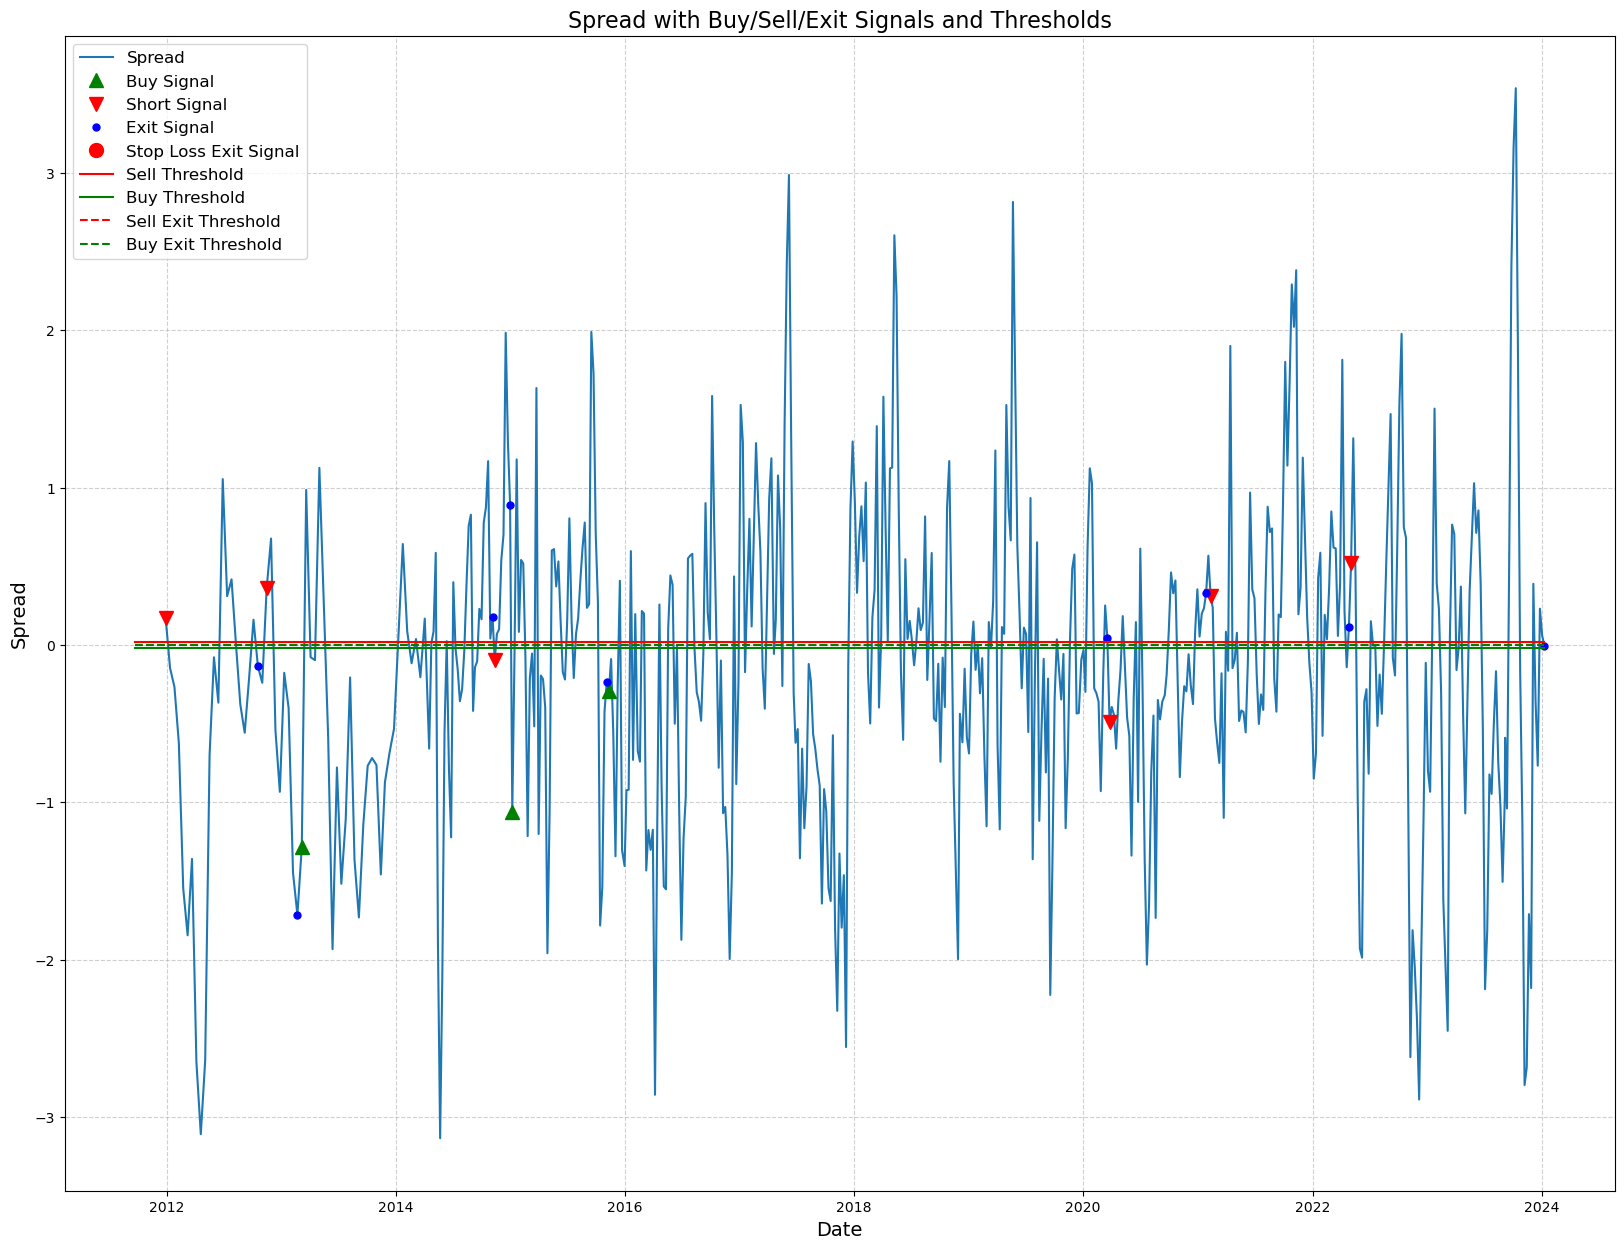

In [234]:
plot_signals(positions_pnl, 0.02, 0)

In [235]:
daily_start_ret = (positions_pnl.total_pnl.diff() / cap).to_frame('strat_returns').dropna()
daily_start_ret

,strat_returns
date,
2011-10-20,0.000000
2011-11-03,0.000000
2011-11-17,0.000000
2011-12-01,0.000000
2011-12-15,0.000000
...,...
2023-11-29,0.014427
2023-12-06,0.007351
2023-12-13,-0.006020


In [236]:
#hit rate
len(gp[gp>0])/len(gp)

0.5388349514563107

In [237]:
gp

position_count
0      0.000000e+00
1      1.283120e+07
2     -9.491108e+06
3      6.763709e+07
4     -9.916529e+06
           ...     
201    6.326026e+06
202    2.498177e+07
203   -9.929182e+06
204   -1.984134e+07
205   -6.199660e+06
Length: 206, dtype: float64

In [238]:
# spy ret

In [239]:
@functools.lru_cache(maxsize=16)
def fetch_etf_data_quadl(ticker,start_date,end_date):
    return quandl.get_table('QUOTEMEDIA/PRICES', date = {'gte':start_date,'lte': end_date}, ticker=ticker)

In [240]:
spy_data = fetch_etf_data_quadl('SPY', '2010-01-15','2024-01-10')

In [241]:
spy_data = spy_data.set_index('date')
spy_data['spy_adj_close'] = spy_data.adj_close.replace(np.inf, np.nan)
spy_data

,ticker,open,high,low,close,volume,dividend,split,adj_open,adj_high,adj_low,adj_close,adj_volume,spy_adj_close
date,,,,,,,,,,,,,,
2024-01-10,SPY,474.160000,477.448100,473.870000,476.560000,66379545.0,0.0,1.0,474.160000,477.448100,473.870000,476.560000,66379545.0,476.560000
2024-01-09,SPY,471.870000,474.930000,471.350000,473.880000,65497238.0,0.0,1.0,471.870000,474.930000,471.350000,473.880000,65497238.0,473.880000
2024-01-08,SPY,468.430000,474.750000,468.300000,474.600000,74232526.0,0.0,1.0,468.430000,474.750000,468.300000,474.600000,74232526.0,474.600000
2024-01-05,SPY,467.490000,470.440000,466.430000,467.920000,85713902.0,0.0,1.0,467.490000,470.440000,466.430000,467.920000,85713902.0,467.920000
2024-01-04,SPY,468.300000,470.960000,467.050000,467.280000,83250038.0,0.0,1.0,468.300000,470.960000,467.050000,467.280000,83250038.0,467.280000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-01-22,SPY,111.199997,111.739998,109.089996,109.209999,345942400.0,0.0,1.0,85.421849,85.836668,83.800984,83.893168,345942400.0,83.893168
2010-01-21,SPY,113.919998,114.269997,111.559998,111.699997,344859600.0,0.0,1.0,87.511305,87.780168,85.698395,85.805940,344859600.0,85.805940
2010-01-20,SPY,114.279999,114.449997,112.980003,113.889999,216490200.0,0.0,1.0,87.787851,87.918440,86.789217,87.488260,216490200.0,87.488260


In [242]:
merged_ret_df = daily_start_ret.merge(spy_data[['spy_adj_close']], left_index=True, right_index=True)
merged_ret_df['spy_returns'] = merged_ret_df['spy_adj_close'].pct_change()
merged_ret_df = merged_ret_df.replace(np.inf,np.nan)
merged_ret_df = merged_ret_df.dropna()
merged_ret_df

,strat_returns,spy_adj_close,spy_returns
date,,,
2011-11-03,0.000000,100.319911,0.037728
2011-11-17,0.000000,97.030213,-0.032792
2011-12-01,0.000000,99.302807,0.023422
2011-12-15,0.000000,97.085835,-0.022325
2011-12-29,0.012831,100.851261,0.038785
...,...,...,...
2023-11-29,0.014427,452.771177,-0.000901
2023-12-06,0.007351,452.920570,0.000330
2023-12-13,-0.006020,468.596904,0.034612


In [243]:
merged_ret_df.corr()

,strat_returns,spy_adj_close,spy_returns
strat_returns,1.000000,-0.107292,0.070815
spy_adj_close,-0.107292,1.000000,-0.003539
spy_returns,0.070815,-0.003539,1.000000


In [244]:
X = merged_ret_df[['spy_returns']]
X = sm.add_constant(X)
model = sm.OLS(X,merged_ret_df[['strat_returns']])

results = model.fit()
results.params


,0,1
strat_returns,-1.283376,0.130966


# Hyperparameter tuning on training data

In [177]:
seed = 1155

In [178]:
def objective(trial:Trial,train=None):

    g = trial.suggest_float('g', 0, 5, step=0.01)
    j = trial.suggest_float('j', 0, g, step=0.01)
    s = trial.suggest_float('s', -0.1, 0, step=0.001)
    reverse = trial.suggest_int('reverse',0,1, step=1)
    
    grouped_pnl, positions_pnl = one_spread_strat(train, K= cap, g=g, j=j, s=s, tc=0, reverse=bool(reverse), interactive_plot=False)

    return positions_pnl['net_dollar_position_change'].sum()

In [179]:
# Trial.suggest_float('g', 0, 5, step=0.1)

In [180]:
study = optuna.create_study(direction="maximize")


In [181]:
# train test split

In [182]:
split = 0.5

In [183]:
train = spreads_df_merged.iloc[:int(len(spreads_df_merged) * split)]
test = spreads_df_merged.iloc[int(len(spreads_df_merged) * (split)):]

In [184]:
train

,mu,sd,skew,kurt,p10,p50,p90,lg_change_decr,prDec,lg_change_incr,...,norm_rolling_prInc,norm_rolling_prDec,CORN,CORN_adj_volume,SOYB,SOYB_adj_volume,spread,dollars_available,spread2,price_spread
date,,,,,,,,,,,,,,,,,,,,,
2011-09-23,-0.007875,0.058621,-0.114580,-0.079516,-0.084706,-0.005990,0.066257,0.0,0.090427,0.0,...,NaN,NaN,43.2100,71000.0,23.46,1000.0,NaN,500000000.0,NaN,NaN
2011-10-06,-0.010665,0.072847,0.060276,-0.159343,-0.103110,-0.012921,0.084966,0.0,0.095295,0.0,...,NaN,NaN,40.5500,34400.0,21.73,1100.0,NaN,500000000.0,NaN,NaN
2011-10-20,-0.008018,0.067386,0.060957,-0.193980,-0.095199,-0.009236,0.079617,0.0,0.093068,0.0,...,NaN,NaN,43.3400,105500.0,22.58,1500.0,NaN,500000000.0,NaN,NaN
2011-11-03,-0.011622,0.067336,0.035617,-0.293945,-0.098424,-0.014156,0.080542,0.0,0.099099,0.0,...,NaN,NaN,43.5400,56900.0,22.52,1000.0,NaN,500000000.0,NaN,NaN
2011-11-17,-0.007733,0.059583,0.092920,-0.350465,-0.084074,-0.012249,0.078139,0.0,0.086221,0.0,...,NaN,NaN,40.2300,93900.0,21.60,0.0,NaN,500000000.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-06-06,-0.014520,0.031830,0.260220,0.326470,-0.043930,-0.025160,0.032520,0.0,0.051980,0.0,...,0.039598,0.606900,17.4800,96037.0,18.07,25987.0,0.039598,500000000.0,-0.602615,-0.602615
2018-06-13,-0.012780,0.026640,-0.100620,-0.305430,-0.044070,-0.015600,0.025980,0.0,0.062380,0.0,...,-1.828594,0.660399,16.9500,203383.0,17.36,50122.0,-1.828594,500000000.0,0.545170,0.545170
2018-06-20,-0.018540,-0.006720,0.292770,0.240790,-0.002130,-0.026230,-0.021220,0.0,0.008570,0.0,...,-2.960129,-1.923550,16.7500,80901.0,16.60,82041.0,-2.960129,500000000.0,0.038021,0.038021


In [185]:
# train.iloc[:60]

In [186]:
test

,mu,sd,skew,kurt,p10,p50,p90,lg_change_decr,prDec,lg_change_incr,...,norm_rolling_prInc,norm_rolling_prDec,CORN,CORN_adj_volume,SOYB,SOYB_adj_volume,spread,dollars_available,spread2,price_spread
date,,,,,,,,,,,,,,,,,,,,,
2018-07-11,-0.01470,-0.02738,0.07589,0.09272,0.02039,-0.01439,-0.04966,0.0,-0.02502,0.0,...,-1.940170,-1.825386,15.940,124055.0,15.7400,249380.0,-1.940170,500000000.0,-0.129036,-0.129036
2018-07-18,-0.01825,-0.02858,0.26291,0.20599,0.02150,-0.02259,-0.05045,0.0,-0.02675,0.0,...,-1.643712,-1.546352,16.200,82118.0,15.9600,100923.0,-1.643712,500000000.0,0.019105,0.019105
2018-07-25,-0.01755,-0.02131,0.18023,0.17703,0.01168,-0.02005,-0.04255,0.0,-0.01673,0.0,...,-1.187769,-0.997452,16.530,183049.0,16.1504,325981.0,-1.187769,500000000.0,0.233079,0.233079
2018-08-01,0.00612,0.02420,-0.16083,-0.10179,-0.02778,0.00989,0.03222,0.0,0.03529,0.0,...,2.236963,1.422511,16.820,43166.0,16.6300,214108.0,2.236963,500000000.0,0.094621,0.094621
2018-08-08,0.00812,0.01442,-0.24043,-0.07338,-0.01461,0.01474,0.01946,0.0,0.02018,0.0,...,1.131676,1.054317,16.850,53757.0,16.7300,69027.0,1.131676,500000000.0,0.142620,0.142620
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-13,-0.02985,0.09499,-0.24592,-1.09549,-0.20938,0.04502,0.02110,0.0,0.17582,0.0,...,0.868960,0.459415,21.945,28134.0,27.8400,11814.0,0.868960,500000000.0,-0.350747,-0.350747
2023-12-20,-0.04183,0.08832,-0.48308,-0.30732,-0.23270,0.02330,-0.01591,0.0,0.11296,0.0,...,0.331438,-1.424111,21.660,45694.0,27.1500,11045.0,0.331438,500000000.0,-0.766858,-0.766858
2023-12-27,-0.01940,0.11635,0.02433,-1.73090,-0.21888,0.07065,0.06030,0.0,0.21084,0.0,...,3.255129,2.002526,21.730,59528.0,27.2800,14571.0,3.255129,500000000.0,0.230352,0.230352


In [187]:
%%time
study.optimize(partial(objective,train=train), n_trials=100,n_jobs=-1)

CPU times: user 2.64 s, sys: 501 ms, total: 3.14 s
Wall time: 2.72 s


## Best Hyperparameters

In [188]:
tuned_args = study.best_params
tuned_args

{'g': 0.79, 'j': 0.06, 's': -0.018000000000000002, 'reverse': 1}

# In-sample performance

<Axes: xlabel='date'>

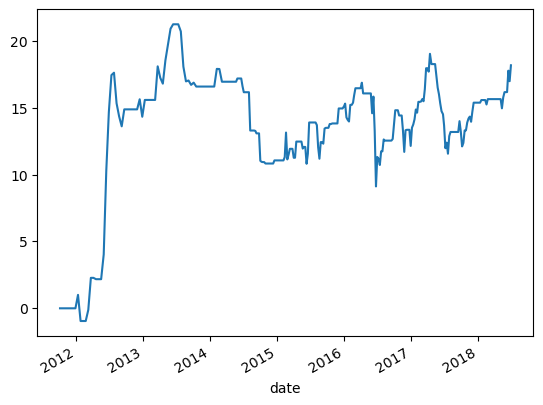

In [189]:
gp, positions_pnl = one_spread_strat(train, K= cap, g=tuned_args['g'], j=tuned_args['j'], s=-100, tc=0, reverse=bool(tuned_args['reverse']), interactive_plot=False)
((positions_pnl.cumulative_pnl - cap) / cap * 100).plot()

## Out-of Sample performance

<Axes: xlabel='date'>

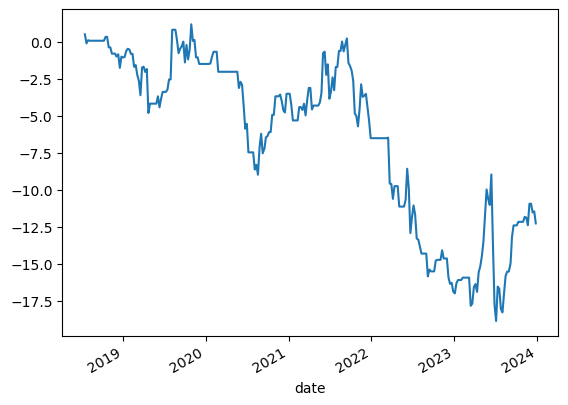

In [190]:
gp, positions_pnl = one_spread_strat(test, K= cap, g=tuned_args['g'], j=tuned_args['j'], s=-100, tc=0, reverse=bool(tuned_args['reverse']), interactive_plot=False)
((positions_pnl.cumulative_pnl - cap) / cap * 100).plot()

# Rolling OOS Performance

insample_lookback = 104 weeks

In [191]:
full_data = spreads_df_merged.copy()
oos_pnl = pd.DataFrame(index=spreads_df_merged.index, columns=['net_pnl'])

for i in range(104, len(full_data)-8, 8):
    
    train = spreads_df_merged.iloc[i-104:i]
    test = spreads_df_merged.iloc[i:i+8]

    seed = 1115
    study.optimize(partial(objective,train=train), n_trials=20,n_jobs=-1)

    tuned_args = study.best_params
    gp, positions_pnl = one_spread_strat(test, K= cap, g=tuned_args['g'], j=tuned_args['j'], 
                                         s=tuned_args['s'], tc=0, reverse=bool(tuned_args['reverse']), interactive_plot=False)

    oos_pnl.loc[test.index,'net_pnl'] = positions_pnl['net_dollar_position_change']


<Axes: xlabel='date'>

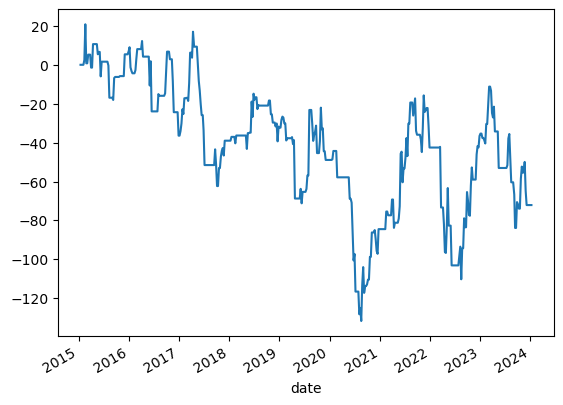

In [192]:
cum_ret = (oos_pnl.fillna(0).cumsum() / cap *10 * 100).loc[spreads_df_merged.index[104:], 'net_pnl']
cum_ret.plot()

# Rolling OOS Performance

insample_lookback = 52 weeks

In [193]:
seed = 11

In [196]:
full_data = spreads_df_merged.copy()
oos_pnl = pd.DataFrame(index=spreads_df_merged.index, columns=['net_pnl'])

for i in range(52, len(full_data)-4, 4):
    
    train = spreads_df_merged.iloc[i-52:i]
    test = spreads_df_merged.iloc[i:i+4]


    study.optimize(partial(objective,train=train), n_trials=10,n_jobs=-1)

    tuned_args = study.best_params
    gp, positions_pnl = one_spread_strat(test, K= cap, g=tuned_args['g'], j=tuned_args['j'], 
                                         s=tuned_args['s'], tc=0, reverse=bool(tuned_args['reverse']), interactive_plot=False)

    oos_pnl.loc[test.index,'net_pnl'] = positions_pnl['net_dollar_position_change']


<Axes: xlabel='date'>

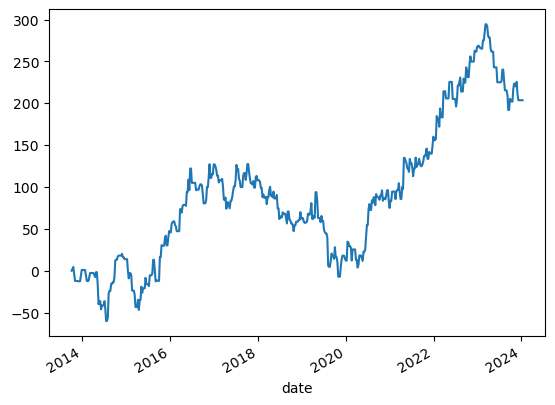

In [197]:
cum_ret = (oos_pnl.fillna(0).cumsum() / cap *10 * 100).loc[spreads_df_merged.index[52:], 'net_pnl']
cum_ret.plot()

insample_lookback = 26 weeks

In [195]:
seed = 11

In [198]:
full_data = spreads_df_merged.copy()
oos_pnl = pd.DataFrame(index=spreads_df_merged.index, columns=['net_pnl'])

for i in range(26, len(full_data)-4, 4):
    
    train = spreads_df_merged.iloc[i-26:i]
    test = spreads_df_merged.iloc[i:i+4]


    study.optimize(partial(objective,train=train), n_trials=10,n_jobs=-1)

    tuned_args = study.best_params
    gp, positions_pnl = one_spread_strat(test, K= cap, g=tuned_args['g'], j=tuned_args['j'], 
                                         s=tuned_args['s'], tc=0, reverse=bool(tuned_args['reverse']), interactive_plot=False)

    oos_pnl.loc[test.index,'net_pnl'] = positions_pnl['net_dollar_position_change']



<Axes: xlabel='date'>

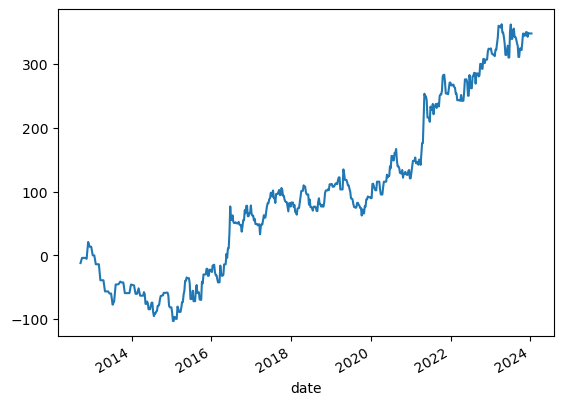

In [254]:
cum_ret = (oos_pnl.fillna(0).cumsum() / cap *10 * 100).loc[spreads_df_merged.index[26:], 'net_pnl']
cum_ret.plot()

Return stats of OOS ret with  26 lookback 

In [255]:
oos_pnl['strat_returns']=(oos_pnl.net_pnl.fillna(0)/cap * 10)
oos_pnl

,net_pnl,strat_returns
date,,
2011-09-23,NaN,0.000000
2011-10-06,NaN,0.000000
2011-10-20,NaN,0.000000
2011-11-03,NaN,0.000000
2011-11-17,NaN,0.000000
...,...,...
2023-12-13,6019731.93,0.060197
2023-12-20,-766523.36,-0.007665
2023-12-27,NaN,0.000000


In [256]:
#Merging ret with SPY

In [257]:
merged_ret_df = oos_pnl.merge(spy_data[['spy_adj_close']], left_index=True, right_index=True)
merged_ret_df['spy_returns'] = merged_ret_df['spy_adj_close'].pct_change()
merged_ret_df = merged_ret_df.replace(np.inf,np.nan)
merged_ret_df = merged_ret_df.dropna()
merged_ret_df

,net_pnl,strat_returns,spy_adj_close,spy_returns
date,,,,
2012-09-20,-11938286.17,-0.119383,118.433717,0.020449
2012-10-04,8153968.4138,0.081540,118.595482,0.001366
2012-10-18,0.0,0.000000,118.343895,-0.002121
2012-11-15,-1375564.554,-0.013756,110.130747,-0.049920
2012-11-29,26388983.0015,0.263890,115.341058,0.047310
...,...,...,...,...
2023-11-15,484343.8676,0.004843,447.861118,0.028428
2023-11-22,5172372.476,0.051724,453.179518,0.011875
2023-12-06,-7350522.38,-0.073505,452.920570,0.000330


In [258]:
merged_ret_df.corr()

,net_pnl,strat_returns,spy_adj_close,spy_returns
net_pnl,1.000000,1.000000,0.051303,-0.027389
strat_returns,1.000000,1.000000,0.051303,-0.027389
spy_adj_close,0.051303,0.051303,1.000000,0.037865
spy_returns,-0.027389,-0.027389,0.037865,1.000000


In [259]:
non_zero_ret = merged_ret_df[merged_ret_df['strat_returns']!=0]
non_zero_ret.corr()

,net_pnl,strat_returns,spy_adj_close,spy_returns
net_pnl,1.000000,1.000000,0.051307,-0.030979
strat_returns,1.000000,1.000000,0.051307,-0.030979
spy_adj_close,0.051307,0.051307,1.000000,0.076240
spy_returns,-0.030979,-0.030979,0.076240,1.000000


In [260]:
X = non_zero_ret[['spy_returns']]
X = sm.add_constant(X)
model = sm.OLS(X,non_zero_ret[['strat_returns']])

results = model.fit()
results.params

,0,1
strat_returns,0.803631,-0.003


### almost 0 Beta to SPY. so strategy is really uncorrelated to market

### OOS Hit Rate

In [261]:
ret=non_zero_ret['strat_returns']
len(ret[ret>0])/len(ret)

0.49056603773584906

In [262]:
def performance_summary(return_data,annualization=52):
    """
    Returns the Performance Stats for a given set of future spreads.
    
    Inputs: 
        spread_data - DataFrame with Date index and Daily Values for a certain futures spread.
    
    Output:
        summary_stats - DataFrame with mean, volatility, and drawdown based on daily spreads.
    """
    # Calculate daily returns from spreads
    
    summary_stats = return_data.mean().to_frame('Ann Mean').apply(lambda x: x * annualization)
    summary_stats['Ann Volatility'] = return_data.std().apply(lambda x: x * np.sqrt(annualization))
    summary_stats['Sharpe Ratio'] = summary_stats['Ann Mean'] / summary_stats['Ann Volatility']

    summary_stats['Skewness'] = return_data.skew()
    summary_stats['Excess Kurtosis'] = return_data.kurtosis()
    summary_stats['VaR (0.05)'] = return_data.quantile(.05, axis=0)
    summary_stats['CVaR (0.05)'] = return_data[return_data <= return_data.quantile(.05, axis=0)].mean()

    wealth_index = 1000 * (1 + return_data).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks) / previous_peaks

    summary_stats['Max Drawdown'] = drawdowns.min()
#     summary_stats['Peak'] = [previous_peaks[col][:drawdowns[col].idxmin()].idxmax() for col in previous_peaks.columns]
#     summary_stats['Bottom'] = drawdowns.idxmin()

    return summary_stats

In [263]:
performance_summary(merged_ret_df[['strat_returns', 'spy_returns']],annualization=52)

,Ann Mean,Ann Volatility,Sharpe Ratio,Skewness,Excess Kurtosis,VaR (0.05),CVaR (0.05),Max Drawdown
strat_returns,0.443925,0.741591,0.598611,0.639700,1.701573,-0.158778,-0.189912,-0.774934
spy_returns,0.174696,0.155411,1.124091,-0.556312,3.558255,-0.033714,-0.052694,-0.189100


In [264]:
# Even though sharpe is less, this is pure alpha because no market correlation

# Strategy based on both price and probability spreads

In [269]:

def two_spread_strat(spreads_df, K= 1e10, g=0.03, g2=0, j=0, s=-100, tc=0, reverse=False, interactive_plot=True):
    
    def get_raw_positions(spreads_df, sl_exit):
        spreads_df = spreads_df.copy()
        spreads_df['signal'] = np.nan

        buy_condition = (spreads_df['spread'] > g)  & (spreads_df['spread2'] < g2)
        sell_condition = (spreads_df['spread'] < -g) & (spreads_df['spread2'] > -g2)
        
        if reverse:
            sell_condition = (spreads_df['spread'] > g)  & (spreads_df['spread2'] < g2)
            buy_condition = (spreads_df['spread'] < -g) & (spreads_df['spread2'] > -g2)

        # Generate signals
        spreads_df.loc[buy_condition, 'signal'] = 1
        spreads_df.loc[sell_condition, 'signal'] = -1

        spreads_df['position'] = spreads_df['signal'].ffill()

        # Exit the position if the spread becomes flat (goes below j)
        sell_exit_cond = (spreads_df['position'] == -1) & (spreads_df['spread'] <= g) & (spreads_df['spread'] >= -j)
        buy_exit_cond = (spreads_df['position'] == 1) & (spreads_df['spread'] >= -g) & (spreads_df['spread'] <= j)
        
        if reverse:
            sell_exit_cond = (spreads_df['position'] == -1) & (spreads_df['spread'] >= -g) & (spreads_df['spread'] <= j)
            buy_exit_cond = (spreads_df['position'] == 1) & (spreads_df['spread'] <= g) & (spreads_df['spread'] >= -j)
        
        if sl_exit is not None:
            spreads_df.loc[sl_exit, 'signal'] = 0

        # last day exit
        spreads_df['signal'].iloc[-1] = 0

        # normal exits
        spreads_df.loc[sell_exit_cond, 'signal'] = 0
        spreads_df.loc[buy_exit_cond, 'signal'] = 0
        spreads_df['position'] = spreads_df['signal'].ffill()

        # Create new_signal column representing changes in position
        spreads_df['final_signal'] = np.nan
        spreads_df['position'].fillna(0, inplace=True)

        spreads_df['new_position'] = 0
        spreads_df.loc[
            (spreads_df['position'].shift() != spreads_df['position']) & (
                        spreads_df['position'] != 0), 'new_position'] = 1
        spreads_df['position_count'] = spreads_df['new_position'].cumsum()

        spreads_df['final_signal'] = spreads_df['position'].diff()

        return spreads_df

    raw_positions = get_raw_positions(spreads_df, None)

    def process_positions(raw_positions):
        positions_df = raw_positions.copy()

        positions_df[security1 + '_' + 'quantity_held'] = np.nan
        positions_df[security2 + '_' + 'quantity_held'] = np.nan

        positions_df.loc[(positions_df.final_signal != 0), security1 + '_' + 'quantity_held'] = positions_df[
                                                                                                    'position'] * (
                                                                                                        positions_df[
                                                                                                            'dollars_available'] /
                                                                                                        positions_df[
                                                                                                            security1]).round()
        positions_df.loc[(positions_df.final_signal != 0), security2 + '_' + 'quantity_held'] = -1 * positions_df[
            'position'] * (positions_df['dollars_available'] / positions_df[security2]).round()

        positions_df[security1 + '_' + 'quantity_held'].ffill(inplace=True)
        positions_df[security2 + '_' + 'quantity_held'].ffill(inplace=True)

        positions_df['net_dollar_position'] = (
                    positions_df[security1 + '_' + 'quantity_held'] * positions_df[security1] +
                    positions_df[security2 + '_' + 'quantity_held'] * positions_df[security2])
        positions_df['gross_dollar_position'] = (
                (positions_df[security1 + '_' + 'quantity_held'] * positions_df[security1]).abs() +
                (positions_df[security2 + '_' + 'quantity_held'] * positions_df[security2]).abs())
        positions_df['net_dollar_position_change'] = (
                positions_df[security1 + '_' + 'quantity_held'].shift() * positions_df[security1].diff() +
                positions_df[security2 + '_' + 'quantity_held'].shift() * positions_df[security2].diff()).shift(-1)

        positions_df['transaction_cost'] = (
                                                   positions_df[security1 + '_' + 'quantity_held'].diff().abs() *
                                                   positions_df[security1] +
                                                   positions_df[security2 + '_' + 'quantity_held'].diff().abs() *
                                                   positions_df[security2]) * tc

        positions_df['position_pnl'] = positions_df.groupby(['position_count'])['net_dollar_position_change'].cumsum()

        positions_df['position_returns'] = (
                positions_df.groupby(['position_count'])['net_dollar_position_change'].cumsum() /
                positions_df.groupby('position_count')['gross_dollar_position'].transform('first'))

        return positions_df

    positions = process_positions(raw_positions)

    def implement_stop_loss(positions, sl_implemented):

        positions_df = positions.copy()

        positions_df['sl_not_hit'] = np.nan
        positions_df.loc[positions_df['new_position'] == 1, 'sl_not_hit'] = 1
        positions_df.loc[positions_df.groupby('position_count')['position_returns'].shift() <= s, 'sl_not_hit'] = 0
        positions_df['sl_not_hit'].ffill(inplace=True)
        positions_df['sl_not_hit'].fillna(1, inplace=True)

        sl_exits = positions_df['sl_not_hit'] == 0

        if sl_implemented:
            return positions_df

        spreads_df = positions_df.loc[:, :'dollars_available']
        raw_positions = get_raw_positions(spreads_df, sl_exits)
        final_positions = process_positions(raw_positions)

        final_positions_sl = implement_stop_loss(final_positions, True)
        return final_positions_sl

    positions_sl_implemented = implement_stop_loss(positions, False)

    def calculate_and_plot_pnl(positions):

        positions = positions.copy()

        grouped_pnl_pct = (positions.groupby('position_count')['net_dollar_position_change'].sum() -
                           positions.groupby('position_count')['transaction_cost'].sum()) 
#         / \
#                           positions.groupby('position_count')['gross_dollar_position'].first()

        positions['total_pnl'] = positions['net_dollar_position_change'].cumsum() - positions[
            'transaction_cost'].cumsum()
        positions['cumulative_pnl'] = positions['total_pnl'] + K

        return grouped_pnl_pct, positions

    grouped_pnl_pct, positions_pnl = calculate_and_plot_pnl(positions_sl_implemented)

    if not interactive_plot:
        return grouped_pnl_pct, positions_pnl

    
    plt.figure(figsize=(12, 8))
    positions_pnl.total_pnl.plot(color='blue', linewidth=2, label='Total PnL')
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Total PnL (USD)', fontsize=14)
    plt.title('Total PnL Over Time', fontsize=16)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(fontsize=12)
    plt.show()

    cumulative_pnl = positions_pnl['cumulative_pnl'].dropna()
    cumulative_returns_percentage = ((cumulative_pnl / cumulative_pnl.iloc[0] - 1) * 100)
    cumulative_returns_percentage.plot(figsize=(12, 8), color='green', linewidth=2)

    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Cumulative Returns (%)', fontsize=14)
    plt.title('Cumulative Returns Over Time', fontsize=16)
    plt.grid(True, linestyle='--', alpha=0.6)

    return positions_pnl.total_pnl



In [270]:
spreads_df_merged['spread'] = spreads_df_merged['norm_rolling_prInc']
spreads_df_merged['spread2'] = spreads_df_merged['norm_rolling_adj_close']
spreads_df_merged['dollars_available'] = cap / 2
spreads_df_merged

,mu,sd,skew,kurt,p10,p50,p90,lg_change_decr,prDec,lg_change_incr,...,norm_rolling_prInc,norm_rolling_prDec,CORN,CORN_adj_volume,SOYB,SOYB_adj_volume,spread,spread2,price_spread,dollars_available
date,,,,,,,,,,,,,,,,,,,,,
2011-09-23,-0.007875,0.058621,-0.114580,-0.079516,-0.084706,-0.005990,0.066257,0.0,0.090427,0.0,...,NaN,NaN,43.210,71000.0,23.46,1000.0,NaN,NaN,NaN,500000000.0
2011-10-06,-0.010665,0.072847,0.060276,-0.159343,-0.103110,-0.012921,0.084966,0.0,0.095295,0.0,...,NaN,NaN,40.550,34400.0,21.73,1100.0,NaN,NaN,NaN,500000000.0
2011-10-20,-0.008018,0.067386,0.060957,-0.193980,-0.095199,-0.009236,0.079617,0.0,0.093068,0.0,...,NaN,NaN,43.340,105500.0,22.58,1500.0,NaN,NaN,NaN,500000000.0
2011-11-03,-0.011622,0.067336,0.035617,-0.293945,-0.098424,-0.014156,0.080542,0.0,0.099099,0.0,...,NaN,NaN,43.540,56900.0,22.52,1000.0,NaN,NaN,NaN,500000000.0
2011-11-17,-0.007733,0.059583,0.092920,-0.350465,-0.084074,-0.012249,0.078139,0.0,0.086221,0.0,...,NaN,NaN,40.230,93900.0,21.60,0.0,NaN,NaN,NaN,500000000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-13,-0.029850,0.094990,-0.245920,-1.095490,-0.209380,0.045020,0.021100,0.0,0.175820,0.0,...,0.868960,0.459415,21.945,28134.0,27.84,11814.0,0.868960,-0.350747,-0.350747,500000000.0
2023-12-20,-0.041830,0.088320,-0.483080,-0.307320,-0.232700,0.023300,-0.015910,0.0,0.112960,0.0,...,0.331438,-1.424111,21.660,45694.0,27.15,11045.0,0.331438,-0.766858,-0.766858,500000000.0
2023-12-27,-0.019400,0.116350,0.024330,-1.730900,-0.218880,0.070650,0.060300,0.0,0.210840,0.0,...,3.255129,2.002526,21.730,59528.0,27.28,14571.0,3.255129,0.230352,0.230352,500000000.0


In [271]:
spreads_df_merged.columns

Index(['mu', 'sd', 'skew', 'kurt', 'p10', 'p50', 'p90', 'lg_change_decr',
       'prDec', 'lg_change_incr', 'prInc', 'adj_close', 'adj_volume',
       'norm_rolling_adj_close', 'norm_rolling_prInc', 'norm_rolling_prDec',
       'CORN', 'CORN_adj_volume', 'SOYB', 'SOYB_adj_volume', 'spread',
       'spread2', 'price_spread', 'dollars_available'],
      dtype='object')

In [272]:
# Pr inc and Price thresholds
# signals reverse
def update_plot(K=1e10, g=0, g2=0, j=0, s=-100, tc = 0, reverse=False):

    positions_pnl = two_spread_strat(spreads_df_merged,K, g, g2, j, s, tc, reverse)


g_slider = np.linspace(0, 5, num=501)
g2_slider = np.linspace(-1, 5, num=601)
j_slider = np.linspace(-1, 5, num=601)
s_slider = np.linspace(-0.1, 0, num=101)
tc_slider = np.linspace(0, 0.00005, num=6)


# Create interactive plot
interactive_plot = interactive(update_plot,K=cap, g=g_slider, g2=g2_slider, j=j_slider, s=s_slider, tc = tc_slider, reverse=False)
output = interactive_plot.children[-1]
interactive_plot

interactive(children=(FloatSlider(value=1000000000.0, description='K', max=3000000000.0, min=-1000000000.0), D…

In [273]:
gp, positions_pnl = two_spread_strat(spreads_df_merged, K= cap, g=0.2, g2=0, j=0, s=-100, tc=0, reverse=True, interactive_plot=False)


In [274]:
# positions_pnl

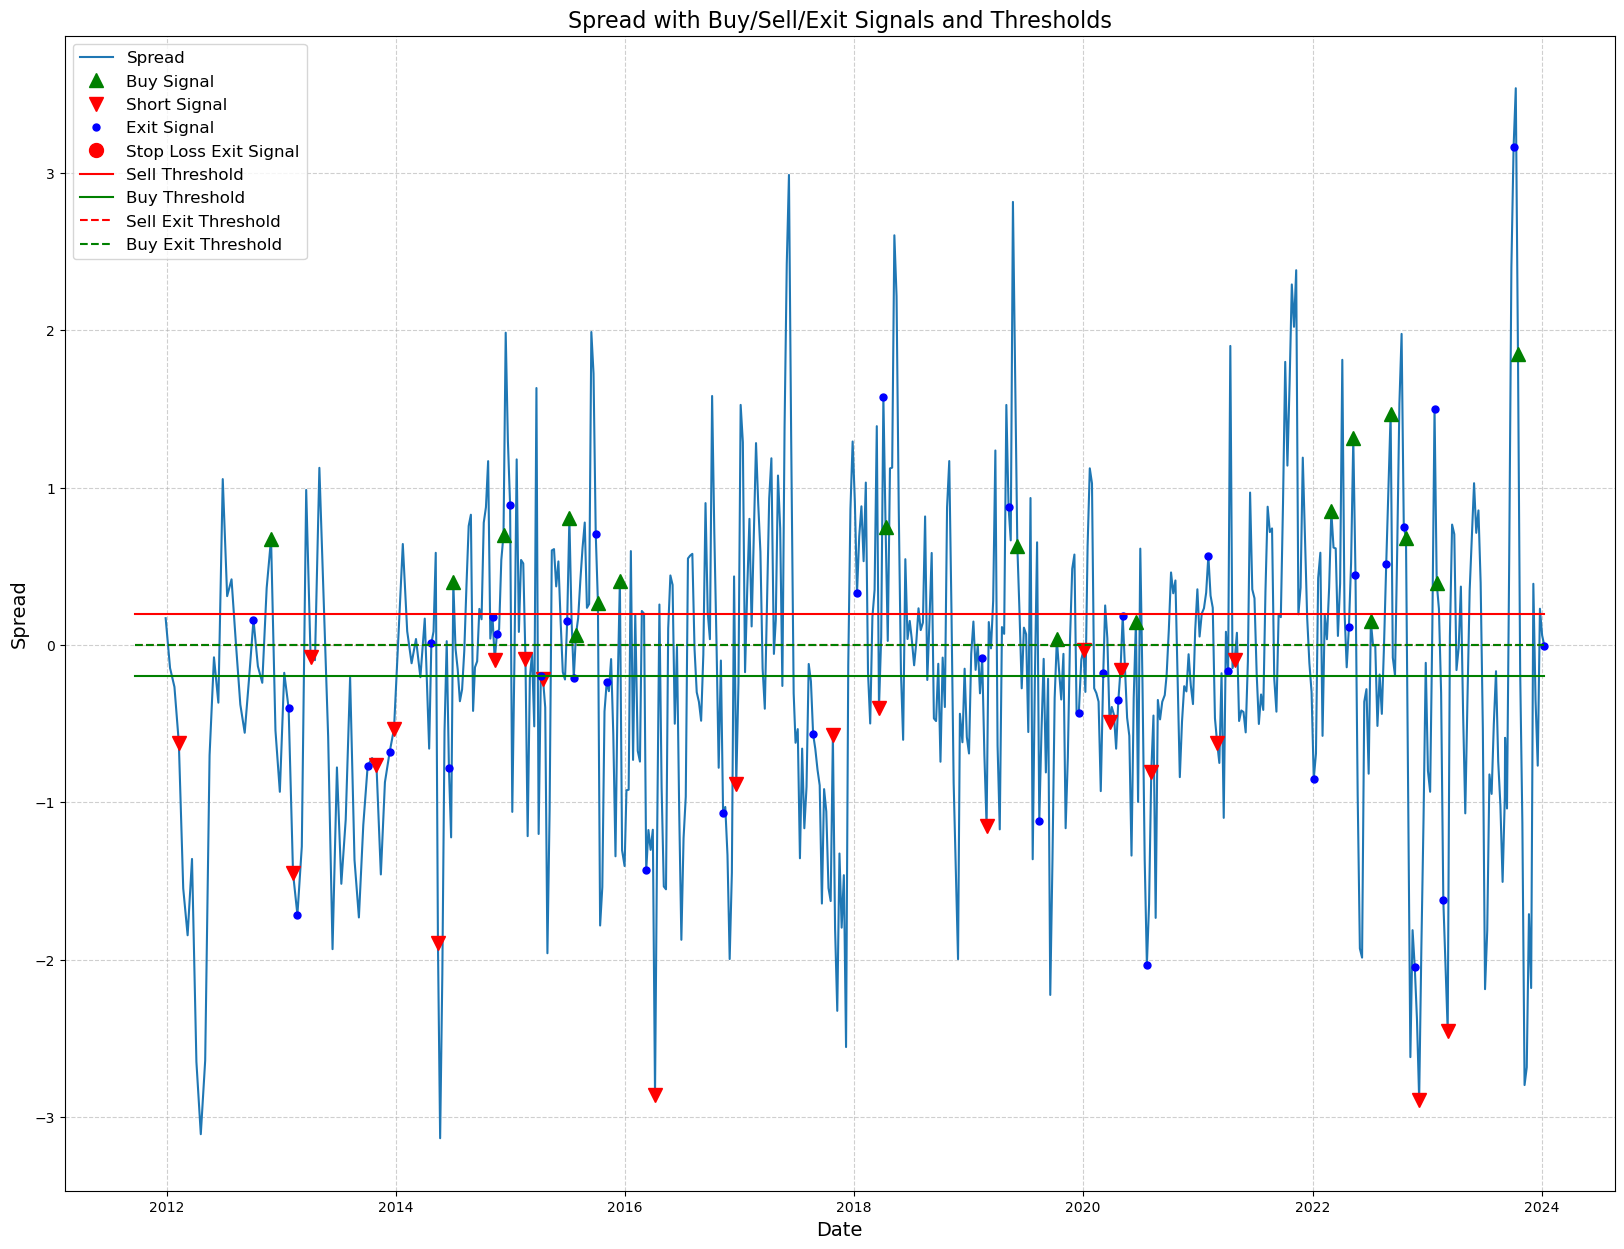

In [275]:
plot_signals(positions_pnl, 0.2, 0)

In [276]:
daily_start_ret = (positions_pnl.total_pnl.diff() / cap).to_frame('strat_returns').dropna()
daily_start_ret

,strat_returns
date,
2011-10-20,0.000000
2011-11-03,0.000000
2011-11-17,0.000000
2011-12-01,0.000000
2011-12-15,0.000000
...,...
2023-11-29,0.014427
2023-12-06,-0.007142
2023-12-13,-0.005899


In [279]:
#hit rate
len(gp[gp>0])/len(gp)

0.4367816091954023

In [280]:
gp

position_count
0     0.000000e+00
1     2.779940e+07
2     3.536767e+07
3    -2.638898e+07
4     7.049427e+06
          ...     
82   -4.796416e+07
83    7.446018e+06
84    2.127305e+07
85   -2.698341e+07
86   -1.332669e+07
Length: 87, dtype: float64

In [281]:
# spy ret

In [282]:
@functools.lru_cache(maxsize=16)
def fetch_etf_data_quadl(ticker,start_date,end_date):
    return quandl.get_table('QUOTEMEDIA/PRICES', date = {'gte':start_date,'lte': end_date}, ticker=ticker)

In [283]:
spy_data = fetch_etf_data_quadl('SPY', '2010-01-15','2024-01-10')

In [284]:
spy_data = spy_data.set_index('date')
spy_data['spy_adj_close'] = spy_data.adj_close.replace(np.inf, np.nan)
spy_data

,ticker,open,high,low,close,volume,dividend,split,adj_open,adj_high,adj_low,adj_close,adj_volume,spy_adj_close
date,,,,,,,,,,,,,,
2024-01-10,SPY,474.160000,477.448100,473.870000,476.560000,66379545.0,0.0,1.0,474.160000,477.448100,473.870000,476.560000,66379545.0,476.560000
2024-01-09,SPY,471.870000,474.930000,471.350000,473.880000,65497238.0,0.0,1.0,471.870000,474.930000,471.350000,473.880000,65497238.0,473.880000
2024-01-08,SPY,468.430000,474.750000,468.300000,474.600000,74232526.0,0.0,1.0,468.430000,474.750000,468.300000,474.600000,74232526.0,474.600000
2024-01-05,SPY,467.490000,470.440000,466.430000,467.920000,85713902.0,0.0,1.0,467.490000,470.440000,466.430000,467.920000,85713902.0,467.920000
2024-01-04,SPY,468.300000,470.960000,467.050000,467.280000,83250038.0,0.0,1.0,468.300000,470.960000,467.050000,467.280000,83250038.0,467.280000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-01-22,SPY,111.199997,111.739998,109.089996,109.209999,345942400.0,0.0,1.0,85.421849,85.836668,83.800984,83.893168,345942400.0,83.893168
2010-01-21,SPY,113.919998,114.269997,111.559998,111.699997,344859600.0,0.0,1.0,87.511305,87.780168,85.698395,85.805940,344859600.0,85.805940
2010-01-20,SPY,114.279999,114.449997,112.980003,113.889999,216490200.0,0.0,1.0,87.787851,87.918440,86.789217,87.488260,216490200.0,87.488260


In [285]:
merged_ret_df = daily_start_ret.merge(spy_data[['spy_adj_close']], left_index=True, right_index=True)
merged_ret_df['spy_returns'] = merged_ret_df['spy_adj_close'].pct_change()
merged_ret_df = merged_ret_df.replace(np.inf,np.nan)
merged_ret_df = merged_ret_df.dropna()
merged_ret_df

,strat_returns,spy_adj_close,spy_returns
date,,,
2011-11-03,0.000000,100.319911,0.037728
2011-11-17,0.000000,97.030213,-0.032792
2011-12-01,0.000000,99.302807,0.023422
2011-12-15,0.000000,97.085835,-0.022325
2011-12-29,0.000000,100.851261,0.038785
...,...,...,...
2023-11-29,0.014427,452.771177,-0.000901
2023-12-06,-0.007142,452.920570,0.000330
2023-12-13,-0.005899,468.596904,0.034612


In [286]:
merged_ret_df.corr()

,strat_returns,spy_adj_close,spy_returns
strat_returns,1.000000,-0.072057,0.033010
spy_adj_close,-0.072057,1.000000,-0.003539
spy_returns,0.033010,-0.003539,1.000000


In [287]:
X = merged_ret_df[['spy_returns']]
X = sm.add_constant(X)
model = sm.OLS(X,merged_ret_df[['strat_returns']])

results = model.fit()
results.params


,0,1
strat_returns,-0.628655,0.0687


# Hyperparameter tuning on training data

In [288]:
seed = 1155

In [289]:
def objective(trial:Trial,train=None):

    g = trial.suggest_float('g', 0, 5, step=0.01)
    g2 = trial.suggest_float('g2', -5, 5, step=0.01)
    j = trial.suggest_float('j', 0, g, step=0.01)
    s = trial.suggest_float('s', -0.1, 0, step=0.001)
    reverse = trial.suggest_int('reverse',0,1, step=1)
    
    grouped_pnl, positions_pnl = two_spread_strat(train, K= cap, g=g, g2=g2, j=j, s=s, tc=0, reverse=bool(reverse), interactive_plot=False)

    return positions_pnl['net_dollar_position_change'].sum()

In [290]:
# Trial.suggest_float('g', 0, 5, step=0.1)

In [291]:
study = optuna.create_study(direction="maximize")


In [292]:
# train test split

In [293]:
split = 0.5

In [294]:
train = spreads_df_merged.iloc[:int(len(spreads_df_merged) * split)]
test = spreads_df_merged.iloc[int(len(spreads_df_merged) * (split)):]

In [295]:
train

,mu,sd,skew,kurt,p10,p50,p90,lg_change_decr,prDec,lg_change_incr,...,norm_rolling_prInc,norm_rolling_prDec,CORN,CORN_adj_volume,SOYB,SOYB_adj_volume,spread,spread2,price_spread,dollars_available
date,,,,,,,,,,,,,,,,,,,,,
2011-09-23,-0.007875,0.058621,-0.114580,-0.079516,-0.084706,-0.005990,0.066257,0.0,0.090427,0.0,...,NaN,NaN,43.2100,71000.0,23.46,1000.0,NaN,NaN,NaN,500000000.0
2011-10-06,-0.010665,0.072847,0.060276,-0.159343,-0.103110,-0.012921,0.084966,0.0,0.095295,0.0,...,NaN,NaN,40.5500,34400.0,21.73,1100.0,NaN,NaN,NaN,500000000.0
2011-10-20,-0.008018,0.067386,0.060957,-0.193980,-0.095199,-0.009236,0.079617,0.0,0.093068,0.0,...,NaN,NaN,43.3400,105500.0,22.58,1500.0,NaN,NaN,NaN,500000000.0
2011-11-03,-0.011622,0.067336,0.035617,-0.293945,-0.098424,-0.014156,0.080542,0.0,0.099099,0.0,...,NaN,NaN,43.5400,56900.0,22.52,1000.0,NaN,NaN,NaN,500000000.0
2011-11-17,-0.007733,0.059583,0.092920,-0.350465,-0.084074,-0.012249,0.078139,0.0,0.086221,0.0,...,NaN,NaN,40.2300,93900.0,21.60,0.0,NaN,NaN,NaN,500000000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-06-06,-0.014520,0.031830,0.260220,0.326470,-0.043930,-0.025160,0.032520,0.0,0.051980,0.0,...,0.039598,0.606900,17.4800,96037.0,18.07,25987.0,0.039598,-0.602615,-0.602615,500000000.0
2018-06-13,-0.012780,0.026640,-0.100620,-0.305430,-0.044070,-0.015600,0.025980,0.0,0.062380,0.0,...,-1.828594,0.660399,16.9500,203383.0,17.36,50122.0,-1.828594,0.545170,0.545170,500000000.0
2018-06-20,-0.018540,-0.006720,0.292770,0.240790,-0.002130,-0.026230,-0.021220,0.0,0.008570,0.0,...,-2.960129,-1.923550,16.7500,80901.0,16.60,82041.0,-2.960129,0.038021,0.038021,500000000.0


In [296]:
# train.iloc[:60]

In [297]:
test

,mu,sd,skew,kurt,p10,p50,p90,lg_change_decr,prDec,lg_change_incr,...,norm_rolling_prInc,norm_rolling_prDec,CORN,CORN_adj_volume,SOYB,SOYB_adj_volume,spread,spread2,price_spread,dollars_available
date,,,,,,,,,,,,,,,,,,,,,
2018-07-11,-0.01470,-0.02738,0.07589,0.09272,0.02039,-0.01439,-0.04966,0.0,-0.02502,0.0,...,-1.940170,-1.825386,15.940,124055.0,15.7400,249380.0,-1.940170,-0.129036,-0.129036,500000000.0
2018-07-18,-0.01825,-0.02858,0.26291,0.20599,0.02150,-0.02259,-0.05045,0.0,-0.02675,0.0,...,-1.643712,-1.546352,16.200,82118.0,15.9600,100923.0,-1.643712,0.019105,0.019105,500000000.0
2018-07-25,-0.01755,-0.02131,0.18023,0.17703,0.01168,-0.02005,-0.04255,0.0,-0.01673,0.0,...,-1.187769,-0.997452,16.530,183049.0,16.1504,325981.0,-1.187769,0.233079,0.233079,500000000.0
2018-08-01,0.00612,0.02420,-0.16083,-0.10179,-0.02778,0.00989,0.03222,0.0,0.03529,0.0,...,2.236963,1.422511,16.820,43166.0,16.6300,214108.0,2.236963,0.094621,0.094621,500000000.0
2018-08-08,0.00812,0.01442,-0.24043,-0.07338,-0.01461,0.01474,0.01946,0.0,0.02018,0.0,...,1.131676,1.054317,16.850,53757.0,16.7300,69027.0,1.131676,0.142620,0.142620,500000000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-13,-0.02985,0.09499,-0.24592,-1.09549,-0.20938,0.04502,0.02110,0.0,0.17582,0.0,...,0.868960,0.459415,21.945,28134.0,27.8400,11814.0,0.868960,-0.350747,-0.350747,500000000.0
2023-12-20,-0.04183,0.08832,-0.48308,-0.30732,-0.23270,0.02330,-0.01591,0.0,0.11296,0.0,...,0.331438,-1.424111,21.660,45694.0,27.1500,11045.0,0.331438,-0.766858,-0.766858,500000000.0
2023-12-27,-0.01940,0.11635,0.02433,-1.73090,-0.21888,0.07065,0.06030,0.0,0.21084,0.0,...,3.255129,2.002526,21.730,59528.0,27.2800,14571.0,3.255129,0.230352,0.230352,500000000.0


In [298]:
%%time
study.optimize(partial(objective,train=train), n_trials=100,n_jobs=-1)

CPU times: user 3.02 s, sys: 551 ms, total: 3.57 s
Wall time: 3.11 s


## Best Hyperparameters

In [299]:
tuned_args = study.best_params
tuned_args

{'g': 0.22, 'g2': 4.32, 'j': 0.08, 's': -0.098, 'reverse': 1}

# In-sample performance

<Axes: xlabel='date'>

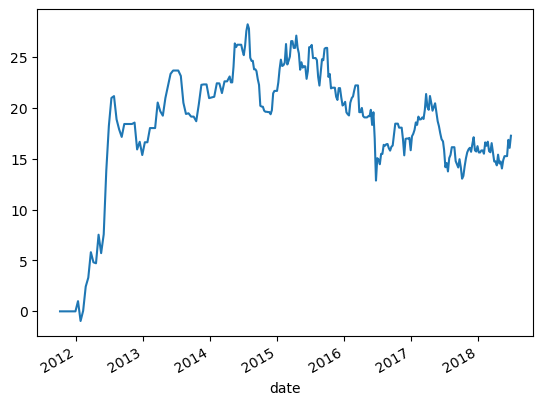

In [300]:
gp, positions_pnl = two_spread_strat(train, K= cap, g=tuned_args['g'], g2=tuned_args['g2'], j=tuned_args['j'], s=-100, tc=0, reverse=bool(tuned_args['reverse']), interactive_plot=False)
((positions_pnl.cumulative_pnl - cap) / cap * 100).plot()

## Out-of Sample performance

<Axes: xlabel='date'>

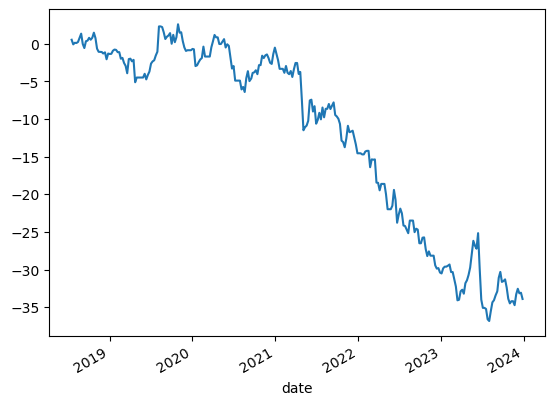

In [301]:
gp, positions_pnl = two_spread_strat(test, K= cap, g=tuned_args['g'], g2=tuned_args['g2'], j=tuned_args['j'], s=-100, tc=0, reverse=bool(tuned_args['reverse']), interactive_plot=False)
((positions_pnl.cumulative_pnl - cap) / cap * 100).plot()

# Rolling OOS Performance

In [323]:

insample_lookback = 104

In [324]:
full_data = spreads_df_merged.copy()
oos_pnl_104 = pd.DataFrame(index=spreads_df_merged.index, columns=['net_pnl'])

for i in range(insample_lookback, len(full_data)-4, 4):
    
    train = spreads_df_merged.iloc[i-insample_lookback:i]
    test = spreads_df_merged.iloc[i:i+4]


    study.optimize(partial(objective,train=train), n_trials=10,n_jobs=-1)

    tuned_args = study.best_params
    gp, positions_pnl = two_spread_strat(test, K= cap, g=tuned_args['g'], g2=tuned_args['g2'], j=tuned_args['j'], 
                                         s=tuned_args['s'], tc=0, reverse=bool(tuned_args['reverse']), interactive_plot=False)

    oos_pnl_104.loc[test.index,'net_pnl'] = positions_pnl['net_dollar_position_change']


In [ ]:
cum_ret = (oos_pnl_104.fillna(0).cumsum() / cap  * 100).loc[spreads_df_merged.index[insample_lookback:], 'net_pnl']
plt.title('OOS Performance with Rolling (52 weeks) Optimized Parameters', fontsize=16)
plt.ylabel('Cumulative Returns (%)', fontsize=14)
plt.xlabel('Date', fontsize=14)
cum_ret.plot()

# Rolling OOS Performance

In [327]:
insample_lookback = 52

In [328]:
seed = 11

In [ ]:
full_data = spreads_df_merged.copy()
oos_pnl_52 = pd.DataFrame(index=spreads_df_merged.index, columns=['net_pnl'])

for i in range(insample_lookback, len(full_data)-4, 4):
    
    train = spreads_df_merged.iloc[i-insample_lookback:i]
    test = spreads_df_merged.iloc[i:i+4]


    study.optimize(partial(objective,train=train), n_trials=10,n_jobs=-1)

    tuned_args = study.best_params
    gp, positions_pnl = two_spread_strat(test, K= cap, g=tuned_args['g'], g2=tuned_args['g2'], j=tuned_args['j'], 
                                         s=tuned_args['s'], tc=0, reverse=bool(tuned_args['reverse']), interactive_plot=False)

    oos_pnl_52.loc[test.index,'net_pnl'] = positions_pnl['net_dollar_position_change']


In [ ]:
cum_ret = (oos_pnl_52.fillna(0).cumsum() / cap * 10 * 100).loc[spreads_df_merged.index[insample_lookback:], 'net_pnl']
cum_ret.plot()

In [ ]:
insample_lookback = 26

In [307]:
seed = 11

In [ ]:
full_data = spreads_df_merged.copy()
oos_pnl_26 = pd.DataFrame(index=spreads_df_merged.index, columns=['net_pnl'])

for i in range(26, len(full_data)-4, 4):
    
    train = spreads_df_merged.iloc[i-26:i]
    test = spreads_df_merged.iloc[i:i+4]


    study.optimize(partial(objective,train=train), n_trials=10,n_jobs=-1)

    tuned_args = study.best_params
    gp, positions_pnl = two_spread_strat(test, K= cap, g=tuned_args['g'], g2=tuned_args['g2'], j=tuned_args['j'], 
                                         s=tuned_args['s'], tc=0, reverse=bool(tuned_args['reverse']), interactive_plot=False)

    oos_pnl_26.loc[test.index,'net_pnl'] = positions_pnl['net_dollar_position_change']


In [ ]:
cum_ret = (oos_pnl_26.fillna(0).cumsum() / cap * 100).loc[spreads_df_merged.index[insample_lookback:], 'net_pnl']
cum_ret.plot()

Return stats of OOS ret with  26 lookback 

In [ ]:
oos_pnl_26['strat_returns']=(oos_pnl.net_pnl.fillna(0)/cap * 10)
oos_pnl_26

In [ ]:
#Merging ret with SPY

In [ ]:
merged_ret_df = oos_pnl.merge(spy_data[['spy_adj_close']], left_index=True, right_index=True)
merged_ret_df['spy_returns'] = merged_ret_df['spy_adj_close'].pct_change()
merged_ret_df = merged_ret_df.replace(np.inf,np.nan)
merged_ret_df = merged_ret_df.dropna()
merged_ret_df

In [ ]:
merged_ret_df.corr()

In [ ]:
non_zero_ret = merged_ret_df[merged_ret_df['strat_returns']!=0]
non_zero_ret.corr()

In [ ]:
X = non_zero_ret[['spy_returns']]
X = sm.add_constant(X)
model = sm.OLS(X,non_zero_ret[['strat_returns']])

results = model.fit()
results.params

### almost 0 Beta to SPY. so strategy is really uncorrelated to market

### OOS Hit Rate

In [ ]:
ret=non_zero_ret['strat_returns']
len(ret[ret>0])/len(ret)

In [ ]:
def performance_summary(return_data,annualization=52):
    """
    Returns the Performance Stats for a given set of future spreads.
    
    Inputs: 
        spread_data - DataFrame with Date index and Daily Values for a certain futures spread.
    
    Output:
        summary_stats - DataFrame with mean, volatility, and drawdown based on daily spreads.
    """
    # Calculate daily returns from spreads
    
    summary_stats = return_data.mean().to_frame('Ann Mean').apply(lambda x: x * annualization)
    summary_stats['Ann Volatility'] = return_data.std().apply(lambda x: x * np.sqrt(annualization))
    summary_stats['Sharpe Ratio'] = summary_stats['Ann Mean'] / summary_stats['Ann Volatility']

    summary_stats['Skewness'] = return_data.skew()
    summary_stats['Excess Kurtosis'] = return_data.kurtosis()
    summary_stats['VaR (0.05)'] = return_data.quantile(.05, axis=0)
    summary_stats['CVaR (0.05)'] = return_data[return_data <= return_data.quantile(.05, axis=0)].mean()

    wealth_index = 1000 * (1 + return_data).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks) / previous_peaks

    summary_stats['Max Drawdown'] = drawdowns.min()
#     summary_stats['Peak'] = [previous_peaks[col][:drawdowns[col].idxmin()].idxmax() for col in previous_peaks.columns]
#     summary_stats['Bottom'] = drawdowns.idxmin()

    return summary_stats

In [ ]:
performance_summary(merged_ret_df[['strat_returns', 'spy_returns']],annualization=52)

In [319]:
# Even though sharpe is less, this is pure alpha because no market correlation